# import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import requests

# Load and merge the data

In [2]:
habits = pd.read_excel('habits_2023_08_23.xlsx')
habits=habits[habits['date']>'2023-04-19']
habits=habits[habits['date']<'2023-08-21']
#sort by date
habits=habits.sort_values(by=['date'])
#reset index
habits=habits.reset_index(drop=True)

# habits['PRF_study_of_happiness']=habits['PRF_study_of_happiness']+habits['PRF_data_science_study']
habits['PRF_reading']=habits['PRF_reading']+habits['PRF_didactic_reading']
#drop PRF_data_science_study
habits=habits.drop(columns=['PRF_didactic_reading'])

print(habits.shape)
print("there is some Na?",habits.isna().sum().sum())#we will take care of this later
habits.describe()

(123, 53)
there is some Na? 0


,date,TIR_time_get_up,EVA_sleep_quality,EVA_happiness_16,EVA_tiredness_16,FRE_siesta,EVA_happiness_22,EVA_tiredness_22,FRE_meditate,XX_FRE_shower,...,PRF_TFMDrissa,day_of_week,EVA_happiness,EVA_tiredness,PRF_sum,FRE_sum,EAT_healthy,VIC,XX_ACT,week
count,123,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,...,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,2023-06-20 00:00:00,10.101620,5.569106,5.741401,5.909318,0.051220,5.626694,5.104289,0.097967,0.585366,...,0.186992,3.048780,5.684047,5.506804,6.363550,4.891809,0.729268,4.783365,0.463415,9.707317
min,2023-04-20 00:00:00,6.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,2.500000,2.500000,0.000000,0.500000,-0.800000,0.834615,0.000000,1.000000
25%,2023-05-20 12:00:00,7.750000,4.000000,4.000000,5.000000,0.000000,4.000000,3.500000,0.000000,0.000000,...,0.000000,1.000000,5.000000,4.500000,2.416667,2.525000,0.100000,3.211801,0.000000,5.000000
50%,2023-06-20 00:00:00,10.000000,6.000000,6.000000,6.000000,0.000000,6.000000,5.769231,0.000000,1.000000,...,0.000000,3.000000,6.000000,5.500000,7.200000,4.100000,0.700000,4.493706,0.000000,10.000000
75%,2023-07-20 12:00:00,12.085000,7.000000,7.000000,7.000000,0.000000,7.000000,6.294872,0.000000,1.000000,...,0.000000,5.000000,6.712340,6.500000,9.500000,7.225000,1.300000,6.034965,1.000000,14.000000
max,2023-08-20 00:00:00,16.000000,9.000000,9.000000,9.000000,1.000000,9.000000,9.000000,1.000000,1.000000,...,6.000000,6.000000,8.000000,8.500000,14.200000,11.500000,3.000000,10.594114,1.000000,18.000000
std,NaN,2.331927,1.954739,1.525420,1.501932,0.150609,1.735208,1.746162,0.202079,0.494674,...,0.943916,2.003496,1.369073,1.269272,3.984225,3.028178,0.853895,2.196270,0.500699,5.096980


In [3]:
#load data from different files and concatenate
garmin1 = pd.read_excel('garmin_2023_05_02.xlsx')
garmin2 = pd.read_excel('garmin_2023_05_31.xlsx')
garmin3 = pd.read_excel('garmin_2023_06_28.xlsx')
garmin4 = pd.read_excel('garmin_2023_07_25.xlsx')
garmin5 = pd.read_excel('garmin_2023_08_23.xlsx')
garmin=pd.concat([garmin1,garmin2,garmin3,garmin4, garmin5])

#drop useless columns
garmin.reset_index(drop=True, inplace=True)
garmin.drop(['SPO_intens_minut_goal', 'SPO_basal_calories', 'SPO_total_calories'], axis=1, inplace=True)#drop useless column
garmin = garmin.sort_values('date')
garmin.reset_index(drop=True, inplace=True)

#garmin.iloc[0:1, 7:8]# to NAn
garmin.iloc[0:1, 7:8] = np.nan

print("there is some Na?",garmin.isna().sum().sum())#We will take care of the Na later
print(garmin.shape)
garmin.describe()

there is some Na? 21
(125, 16)


,date,TIR_body_bat_0h,TIR_body_bat_4h,TIR_body_bat_8h,TIR_body_bat_12h,TIR_body_bat_16h,TIR_body_bat_20h,TIR_body_bat_mean,TIR_sleep_time,TIR_sleep_score,TIR_stress,SPO_card_freq_rest,SPO_active_calories,SPO_intens_minut_value,SPO_steps,SPO_steps_goal
count,125,124.000000,124.000000,124.000000,124.000000,125.000000,125.000000,124.000000,124.000000,124.000000,125.000000,124.000000,125.000000,112.000000,125.000000,125.000000
mean,2023-06-21 00:00:00,13.233871,66.790323,71.685484,55.104839,50.192000,17.856000,45.674731,7.661694,81.709677,38.048000,44.370968,421.904000,24.553571,5829.712000,5862.400000
min,2023-04-20 00:00:00,5.000000,5.000000,5.000000,14.000000,6.000000,5.000000,8.833333,4.083333,25.000000,21.000000,38.000000,12.000000,0.000000,74.000000,3740.000000
25%,2023-05-22 00:00:00,5.000000,46.500000,52.750000,44.750000,43.000000,9.000000,36.708333,6.795833,76.000000,33.000000,42.000000,150.000000,0.000000,3368.000000,5040.000000
50%,2023-06-22 00:00:00,10.000000,74.000000,86.500000,52.500000,51.000000,16.000000,48.916667,7.458333,84.000000,38.000000,44.000000,278.000000,3.000000,4539.000000,5770.000000
75%,2023-07-22 00:00:00,18.000000,92.000000,97.250000,62.250000,60.000000,22.000000,54.458333,8.429167,92.000000,42.000000,46.000000,548.000000,20.000000,6532.000000,6660.000000
max,2023-08-20 00:00:00,83.000000,100.000000,100.000000,100.000000,100.000000,84.000000,68.666667,11.450000,100.000000,63.000000,57.000000,1848.000000,235.000000,15746.000000,8430.000000
std,NaN,10.779466,29.762549,30.859600,18.806165,15.349002,12.544568,12.943520,1.350041,14.055508,7.715564,3.254685,385.583626,45.805078,3714.761308,1148.146754


In [4]:
#merge habits and garmin dataframes
felicity = pd.merge(habits,garmin , on='date', how='outer')

# FIX NA IN "GARMIN" COLUMNS (THE FIRST 5 ROWS & 1 OTHER ROW)

#fill 'TIR_body_bat_0h' NaN with mean of the day of the week (for rows below 2023-07-24)
mask_minus_07_24 = felicity['date'] < '2023-07-24'
mean_day_TIR_body_bat_0h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_0h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_0h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_0h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_0h))

#fill 'TIR_body_bat_4h' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_body_bat_4h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_4h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_4h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_4h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_4h))

#fill 'TIR_body_bat_8h' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_body_bat_8h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_8h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_8h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_8h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_8h))

#fill 'TIR_body_bat_12h' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_body_bat_12h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_12h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_12h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_12h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_12h))

#fill 'TIR_body_bat_16h' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_body_bat_16h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_16h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_16h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_16h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_16h))

#fill 'TIR_body_bat_20h' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_body_bat_20h=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_body_bat_20h'].mean()
felicity.loc[mask_minus_07_24, 'TIR_body_bat_20h'] = felicity.loc[mask_minus_07_24, 'TIR_body_bat_20h'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_body_bat_20h))

#for rows where 'TIR_body_bat_mean' is NaN, fill with mean of the previous updated columns
felicity['TIR_body_bat_mean'].fillna(felicity[['TIR_body_bat_0h', 'TIR_body_bat_4h', 'TIR_body_bat_8h', 'TIR_body_bat_12h', 'TIR_body_bat_16h', 'TIR_body_bat_20h']].mean(axis=1), inplace=True)

#fill 'TIR_sleep_time' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_sleep_time=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_sleep_time'].mean()
felicity.loc[mask_minus_07_24, 'TIR_sleep_time'] = felicity.loc[mask_minus_07_24, 'TIR_sleep_time'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_sleep_time))

#fill 'TIR_sleep_score' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_sleep_score=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_sleep_score'].mean()
felicity.loc[mask_minus_07_24, 'TIR_sleep_score'] = felicity.loc[mask_minus_07_24, 'TIR_sleep_score'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_sleep_score))

#fill 'TIR_stress' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_TIR_stress=felicity[mask_minus_07_24].groupby('day_of_week')['TIR_stress'].mean()
felicity.loc[mask_minus_07_24, 'TIR_stress'] = felicity.loc[mask_minus_07_24, 'TIR_stress'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_TIR_stress))

#fill 'SPO_card_freq_rest' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_SPO_card_freq_rest=felicity[mask_minus_07_24].groupby('day_of_week')['SPO_card_freq_rest'].mean()
felicity.loc[mask_minus_07_24, 'SPO_card_freq_rest'] = felicity.loc[mask_minus_07_24, 'SPO_card_freq_rest'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_SPO_card_freq_rest))

#fill 'SPO_active_calories' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_SPO_active_calories=felicity[mask_minus_07_24].groupby('day_of_week')['SPO_active_calories'].mean()
felicity.loc[mask_minus_07_24, 'SPO_active_calories'] = felicity.loc[mask_minus_07_24, 'SPO_active_calories'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_SPO_active_calories))

#fill 'SPO_intens_minut_value' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_SPO_intens_minut_value=felicity[mask_minus_07_24].groupby('day_of_week')['SPO_intens_minut_value'].mean()
felicity.loc[mask_minus_07_24, 'SPO_intens_minut_value'] = felicity.loc[mask_minus_07_24, 'SPO_intens_minut_value'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_SPO_intens_minut_value))

#fill 'SPO_steps' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_SPO_steps=felicity[mask_minus_07_24].groupby('day_of_week')['SPO_steps'].mean()
felicity.loc[mask_minus_07_24, 'SPO_steps'] = felicity.loc[mask_minus_07_24, 'SPO_steps'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_SPO_steps))

#fill 'SPO_steps_goal' NaN with mean of the day of the week (for rows below 2023-07-24)
mean_day_SPO_steps_goal=felicity[mask_minus_07_24].groupby('day_of_week')['SPO_steps_goal'].mean()
felicity.loc[mask_minus_07_24, 'SPO_steps_goal'] = felicity.loc[mask_minus_07_24, 'SPO_steps_goal'].fillna(felicity.loc[mask_minus_07_24, 'day_of_week'].map(mean_day_SPO_steps_goal))

#sort by date
felicity=felicity.sort_values(by=['date'])
#reset index
felicity=felicity.reset_index(drop=True)

#Check if there is any NaN left
print("felicity NAs:",felicity.isna().sum().sum())
print("\nNA for Garmin:",felicity.iloc[:,54:].isna().sum().sum())#No missing values for Garmin columns
print("Row(s) for Garmin NA:",felicity[felicity.iloc[:,54:69].isna().any(axis=1)].index)#show rows with missing values
print("\nNA for Habits:",felicity.iloc[:,:54].isna().sum().sum())#Missing values for Habit columns
print("Row(s) for Habits NA:",felicity[felicity.iloc[:,:54].isna().any(axis=1)].index,"\n")#show rows with missing values
print(felicity.shape)
felicity.describe()

felicity NAs: 0

NA for Garmin: 0
Row(s) for Garmin NA: Index([], dtype='int64')

NA for Habits: 0
Row(s) for Habits NA: Index([], dtype='int64') 

(126, 68)


,date,TIR_time_get_up,EVA_sleep_quality,EVA_happiness_16,EVA_tiredness_16,FRE_siesta,EVA_happiness_22,EVA_tiredness_22,FRE_meditate,XX_FRE_shower,...,TIR_body_bat_20h,TIR_body_bat_mean,TIR_sleep_time,TIR_sleep_score,TIR_stress,SPO_card_freq_rest,SPO_active_calories,SPO_intens_minut_value,SPO_steps,SPO_steps_goal
count,126,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,2023-06-20 14:40:00,10.079359,5.595238,5.763431,5.903541,0.051984,5.635582,5.109743,0.101984,0.595238,...,17.849206,45.869760,7.655932,81.679487,38.030525,44.366911,419.937118,25.496873,5815.019536,5861.996337
min,2023-04-20 00:00:00,6.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,5.000000,8.833333,4.083333,25.000000,21.000000,38.000000,12.000000,0.000000,74.000000,3740.000000
25%,2023-05-21 06:00:00,7.750000,4.000000,4.000000,5.000000,0.000000,4.000000,3.250000,0.000000,0.000000,...,9.000000,37.333333,6.816667,76.250000,33.000000,42.000000,150.500000,0.000000,3382.000000,5052.500000
50%,2023-06-21 12:00:00,10.000000,6.000000,6.000000,6.000000,0.000000,6.000000,5.834615,0.000000,1.000000,...,16.500000,49.333333,7.458333,84.000000,37.500000,44.000000,277.500000,5.000000,4537.500000,5775.000000
75%,2023-07-21 18:00:00,12.000000,7.000000,7.000000,7.000000,0.000000,7.000000,6.439103,0.075000,1.000000,...,22.000000,54.708333,8.366667,92.000000,42.000000,46.000000,542.750000,29.750000,6531.000000,6657.500000
max,2023-08-20 00:00:00,16.000000,9.000000,9.000000,9.000000,1.000000,9.000000,9.000000,1.000000,1.000000,...,84.000000,68.666667,11.450000,100.000000,63.000000,57.000000,1848.000000,235.000000,15746.000000,8430.000000
std,NaN,2.317798,1.943928,1.520675,1.512737,0.149987,1.729147,1.745413,0.203804,0.492805,...,12.494522,12.975876,1.340186,13.948021,7.687143,3.228998,384.672304,43.708902,3703.546327,1143.553921


In [5]:
climate=pd.read_csv('climate_2023-04-17_2023-08-20.csv')
climate['date'] = pd.to_datetime(climate['date'])
climate['tRange'] = climate['tmax'] - climate['tmin']
climate.drop(['tmin'], axis=1, inplace=True)
climate

,date,tmed,prec,tmax,tRange
0,2023-04-17,15.2,0.1,18.3,6.1
1,2023-04-18,15.7,0.8,18.2,5.0
2,2023-04-19,15.1,3.9,17.2,4.3
3,2023-04-20,15.0,4.3,17.7,5.3
4,2023-04-21,15.9,9.0,18.2,4.5
...,...,...,...,...,...
121,2023-08-16,26.0,0.0,28.1,4.3
122,2023-08-17,26.2,0.0,28.2,4.1
123,2023-08-18,26.6,0.0,29.5,5.7
124,2023-08-19,27.6,0.0,30.1,5.1


In [6]:
#merge habits and climate through date
felicity = pd.merge(felicity, climate, on='date', how='left')
felicity.sort_values(by=['date'], inplace=True)
felicity.reset_index(drop=True, inplace=True)
print(felicity.shape)
felicity.tail()

(126, 72)


,date,TIR_time_get_up,EVA_sleep_quality,EVA_happiness_16,EVA_tiredness_16,FRE_siesta,EVA_happiness_22,EVA_tiredness_22,FRE_meditate,XX_FRE_shower,...,TIR_stress,SPO_card_freq_rest,SPO_active_calories,SPO_intens_minut_value,SPO_steps,SPO_steps_goal,tmed,prec,tmax,tRange
121,2023-08-16,11.75,8.0,7.0,4.0,0.0,7.0,3.0,0.0,0,...,41.0,41.0,116.0,0.0,2980.0,4170.0,26.0,0.0,28.1,4.3
122,2023-08-17,12.70,9.0,6.0,3.0,0.0,7.0,2.0,0.0,1,...,40.0,41.0,277.0,3.0,3682.0,3940.0,26.2,0.0,28.2,4.1
123,2023-08-18,11.50,6.0,7.0,7.0,0.0,8.0,3.0,0.0,0,...,50.0,41.0,673.0,2.0,3099.0,3890.0,26.6,0.0,29.5,5.7
124,2023-08-19,13.75,4.0,4.0,8.0,0.0,3.0,7.0,0.0,0,...,45.0,41.0,260.0,0.0,4077.0,3740.0,27.6,0.0,30.1,5.1
125,2023-08-20,14.75,9.0,3.0,7.0,0.0,2.0,6.0,0.0,0,...,21.0,40.0,32.0,0.0,1073.0,3780.0,28.6,0.0,32.1,6.9


In [7]:
activities = pd.read_excel('activities_2023_08_23.xlsx')
#drop useless column
activities.drop(['Altura_max', 'Altura_mínima', 'Número_vueltas', 'Mejor_tiempo_vuelta', 'Repeticiones_totales'], axis=1, inplace=True)
activities = activities.sort_values('date')
activities.reset_index(drop=True, inplace=True)

#add prefix SPORT_ to all columns except 'date'
activities = activities.add_prefix('SPORT_')
activities.rename(columns={'SPORT_date':'date',}, inplace=True)

#SPORT_Tipo_actividad to numerical
activities.loc[activities['SPORT_Tipo_actividad']=='Caminar','SPORT_Tipo_actividad'] = 1
activities.loc[activities['SPORT_Tipo_actividad']=='Entreno de fuerza','SPORT_Tipo_actividad'] = 2
activities.loc[activities['SPORT_Tipo_actividad']=='Cardio','SPORT_Tipo_actividad'] = 3
activities.loc[activities['SPORT_Tipo_actividad']=='Carrera','SPORT_Tipo_actividad'] = 4

#replace 0 with NaN of some columns
activities['SPORT_Cadencia_med_pedaleo'].replace(0, np.nan, inplace=True)
activities['SPORT_Cadencia_pedaleo_max'].replace(0, np.nan, inplace=True)
activities['SPORT_Ritmo_med'].replace(0, np.nan, inplace=True)
activities['SPORT_Ritmo_mejor'].replace(0, np.nan, inplace=True)
activities['SPORT_Ascenso_total'].replace(0, np.nan, inplace=True)
activities['SPORT_Descenso_total'].replace(0, np.nan, inplace=True)
activities['SPORT_Longitud_med_zancada'].replace(0, np.nan, inplace=True)

#there could be double rows for the same date (for example 'date'='2023-06-08'), so we group by date and aggregate the values
agg_dict = {
    'SPORT_Tipo_actividad': 'sum',
    'SPORT_Distancia': 'sum',
    'SPORT_Calorías': 'sum',
    'SPORT_Tiempo': 'sum',
    'SPORT_Frecuencia_cardiaca_med': 'mean',
    'SPORT_FC_max': 'mean',
    'SPORT_time': 'first',
    'SPORT_Cadencia_med_pedaleo': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Cadencia_pedaleo_max': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Ritmo_med': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Ritmo_mejor': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Ascenso_total': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Descenso_total': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x),
    'SPORT_Longitud_med_zancada': lambda x: np.nansum(x) if np.isnan(x).any() else np.nanmean(x)
}
activities = activities.groupby('date').agg(agg_dict).reset_index()

print("activities NAs:",activities.isna().sum().sum())
print("\n",activities.shape)
activities.describe()

activities NAs: 0

 (18, 15)


,date,SPORT_Distancia,SPORT_Calorías,SPORT_Tiempo,SPORT_Frecuencia_cardiaca_med,SPORT_FC_max,SPORT_Cadencia_med_pedaleo,SPORT_Cadencia_pedaleo_max,SPORT_Ritmo_med,SPORT_Ritmo_mejor,SPORT_Ascenso_total,SPORT_Descenso_total,SPORT_Longitud_med_zancada
count,18,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,2023-06-10 14:40:00,4.606111,661.722222,57.774074,156.138889,182.888889,97.388889,121.333333,4.579630,2.978704,53.111111,62.000000,0.756111
min,2023-04-22 00:00:00,0.000000,272.000000,29.366667,93.000000,125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-05-04 00:00:00,0.000000,505.750000,40.812500,142.750000,174.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-15 00:00:00,5.845000,640.000000,50.858333,164.750000,190.000000,155.500000,164.000000,5.108333,3.908333,26.000000,69.500000,1.065000
75%,2023-07-11 12:00:00,6.937500,730.750000,59.833333,174.250000,195.000000,157.000000,178.750000,5.937500,4.395833,93.750000,90.750000,1.180000
max,2023-08-10 00:00:00,9.690000,1187.000000,136.500000,185.000000,197.000000,160.000000,236.000000,20.333333,8.200000,161.000000,152.000000,1.290000
std,NaN,3.519410,230.787604,27.526025,25.106717,17.956283,74.587603,90.256497,4.799862,2.396953,58.772632,53.620672,0.559970


In [8]:
felicity = pd.merge(felicity,activities , on='date', how='outer')

#Check if there is any NaN left
print("felicity NAs:",felicity.isna().sum().sum())

print("\nNA for Garmin:",felicity.iloc[:,54:69].isna().sum().sum())#No missing values for Garmin columns
print("Row(s) for Garmin NA:",felicity[felicity.iloc[:,54:69].isna().any(axis=1)].index)#show rows with missing values

print("\nNA for Habits:",felicity.iloc[:,:54].isna().sum().sum())#Missing values for Habit columns
print("Row(s) for Habits NA:",felicity[felicity.iloc[:,:54].isna().any(axis=1)].index)#show rows with missing values

print("\nNA for activities:",felicity.iloc[:,69:].isna().sum().sum())#Only a few days I do activities, so I have lots of missing values
print("Row(s) for activities NA:",felicity[felicity.iloc[:,69:].isna().any(axis=1)].index)#show rows with missing values
print(felicity.shape)
felicity.describe()

felicity NAs: 1498

NA for Garmin: 0
Row(s) for Garmin NA: Index([], dtype='int64')

NA for Habits: 0
Row(s) for Habits NA: Index([], dtype='int64')

NA for activities: 1498
Row(s) for activities NA: Index([  0,   1,   3,   6,   7,   8,  10,  11,  12,  14,
       ...
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125],
      dtype='int64', length=107)
(126, 86)


,date,TIR_time_get_up,EVA_sleep_quality,EVA_happiness_16,EVA_tiredness_16,FRE_siesta,EVA_happiness_22,EVA_tiredness_22,FRE_meditate,XX_FRE_shower,...,SPORT_Tiempo,SPORT_Frecuencia_cardiaca_med,SPORT_FC_max,SPORT_Cadencia_med_pedaleo,SPORT_Cadencia_pedaleo_max,SPORT_Ritmo_med,SPORT_Ritmo_mejor,SPORT_Ascenso_total,SPORT_Descenso_total,SPORT_Longitud_med_zancada
count,126,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2023-06-20 14:40:00,10.079359,5.595238,5.763431,5.903541,0.051984,5.635582,5.109743,0.101984,0.595238,...,56.502632,156.815789,183.210526,100.421053,123.631579,4.643860,3.054386,53.368421,61.789474,0.774737
min,2023-04-20 00:00:00,6.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,...,29.366667,93.000000,125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-05-21 06:00:00,7.750000,4.000000,4.000000,5.000000,0.000000,4.000000,3.250000,0.000000,0.000000,...,39.425000,144.500000,176.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-21 12:00:00,10.000000,6.000000,6.000000,6.000000,0.000000,6.000000,5.834615,0.000000,1.000000,...,50.266667,165.000000,189.000000,155.000000,165.000000,5.233333,3.916667,36.000000,58.000000,1.070000
75%,2023-07-21 18:00:00,12.000000,7.000000,7.000000,7.000000,0.000000,7.000000,6.439103,0.075000,1.000000,...,58.733333,172.500000,195.000000,157.000000,177.500000,5.891667,4.416667,86.500000,90.500000,1.180000
max,2023-08-20 00:00:00,16.000000,9.000000,9.000000,9.000000,1.000000,9.000000,9.000000,1.000000,1.000000,...,136.500000,185.000000,197.000000,160.000000,236.000000,20.333333,8.200000,161.000000,152.000000,1.290000
std,NaN,2.317798,1.943928,1.520675,1.512737,0.149987,1.729147,1.745413,0.203804,0.492805,...,27.318554,24.577096,17.506599,73.681232,88.283766,4.673022,2.352664,57.127742,52.118006,0.550216


# Feature engineering

In [9]:
felicity.rename(columns={'EVA_sleep_quality':'EVA_TIR_sleep_quality', 'EVA_tiredness_16':'EVA_TIR_tiredness_16', 'EVA_tiredness_22':'EVA_TIR_tiredness_22', 'FRE_meditate':'FRE_TIR_meditate', 'EVA_tiredness':'EVA_TIR_tiredness'}, inplace=True)
felicity.rename(columns={'FRE_transport':'PRF_FRE_transport',}, inplace=True)
felicity.rename(columns={'XX_PRF_chess':'XX_PRF_FRE_chess',}, inplace=True)
felicity.rename(columns={'XX_EAT_meat':'XX_EAT_VIC_meat', 'XX_EAT_processed':'XX_EAT_VIC_processed', 'FRE_audiovisual_content':'FRE_VIC_audiovisual_content', 'XX_FRE_anime':'XX_FRE_VIC_anime', 'XX_FRE_self_touching':'XX_VIC_self_touching',}, inplace=True)

In [10]:
# habits['day_of_week'] to number
felicity['day_of_week'] = felicity['date'].dt.dayofweek
felicity['month'] = felicity['date'].dt.month

# Ordenar el dataframe por la columna "date"
felicity = felicity.sort_values('date')
felicity.reset_index(drop=True, inplace=True)

# Obtener el año y el número de semana para la primera fecha en el dataframe
start_year = felicity['date'].iloc[0].year
start_week = felicity['date'].iloc[0].isocalendar().week

# Crear la columna "week" utilizando el año y el número de semana secuencialmente
felicity['week'] = (felicity['date'].dt.year - start_year) * 52 + (felicity['date'].apply(lambda x: x.isocalendar().week) - start_week + 1)

print(felicity.shape)

(126, 87)


In [11]:
# Aplicar codificación cíclica al mes y día de la semana
felicity['month_sin'] = np.sin(2 * np.pi * felicity['month'] / 12)
felicity['month_cos'] = np.cos(2 * np.pi * felicity['month'] / 12)
felicity['day_of_week_sin'] = np.sin(2 * np.pi * felicity['day_of_week'] / 7)
felicity['day_of_week_cos'] = np.cos(2 * np.pi * felicity['day_of_week'] / 7)

# Eliminar las columnas originales de fechas si ya no las necesitas
felicity.drop(['month','day_of_week'], axis=1, inplace=True)
print(felicity.shape)

(126, 89)


In [12]:
felicity.rename(columns={'XX_VIC_self_touching':'XX_VIC_self_pleasure','tmed':'ALI_tmed', 'prec':'ALI_prec', 'tmax':'ALI_tmax', 'tRange':'ALI_trange', 'week':'ALI_week', 'month_sin':'ALI_month_sin', 'month_cos':'ALI_month_cos', 'day_of_week_sin':'ALI_day_of_week_sin', 'day_of_week_cos':'ALI_day_of_week_cos'}, inplace=True)

In [13]:
#count as sport if I do more than 60 pull ups
felicity.loc[felicity['SPO_pull_ups']>=60, 'SPO_sport']=2

#SPO_sport fill na 0
felicity['SPO_sport'].fillna(0, inplace=True)
felicity['SPORT_Tipo_actividad'].fillna(0, inplace=True)

#create SPO_sport.column
felicity['SPO_sport'] = felicity['SPO_sport'] + felicity['SPORT_Tipo_actividad']

#drop SPORT_ columns
felicity.drop(felicity.filter(regex='SPORT').columns, axis=1, inplace=True)

#AÑADIR +0.5 A SPO_SPORT SI SE CUMPLEN CIERTAS CONDICIONES
condition = (felicity['SPO_active_calories'] > 550) & (felicity['SPO_sport'] == 0)
felicity.loc[condition, 'SPO_sport'] += 0.5

condition = (felicity['SPO_intens_minut_value'] > 29) & (felicity['SPO_sport'] == 0)
felicity.loc[condition, 'SPO_sport'] += 0.5

condition = (felicity['SPO_steps'] > 6565) & (felicity['SPO_sport'] == 0)
felicity.loc[condition, 'SPO_sport'] += 0.5

print(felicity.shape)
felicity['SPO_sport'].describe()

(126, 76)


count    126.000000
mean       0.916667
std        1.542401
min        0.000000
25%        0.000000
50%        0.000000
75%        1.750000
max        7.000000
Name: SPO_sport, dtype: float64

In [14]:
#redondear algunas columnas
columns_round2=['TIR_time_get_up']
felicity[columns_round2]=felicity[columns_round2].round(2)
columns_round1=['EVA_happiness_16', 'EVA_TIR_tiredness_16', 'EVA_happiness_22', 'EVA_TIR_tiredness_22', 'EVA_happiness', 'EVA_TIR_tiredness', ]
felicity[columns_round1]=felicity[columns_round1].round(1)
columns_round0=['TIR_sleep_score', 'TIR_stress', 'SPO_card_freq_rest', 'SPO_active_calories', 'SPO_intens_minut_value', 'SPO_steps', 'SPO_steps_goal']
felicity[columns_round0]=felicity[columns_round0].round(0)

In [15]:
#CREAR TIR

#crear 'TIR_sleep_score_mix'
felicity['TIR_sleep_score_mix'] = felicity['TIR_sleep_score']/10*0.6+felicity['EVA_TIR_sleep_quality']*0.4

# invert 'TIR_body_bat_mean'
felicity['inverted_bat'] = 1 / (felicity['TIR_body_bat_mean']/10)
#scale 'TIR_body_bat_mean' between 2.5 and 8.5
min_scaled_bat = felicity['inverted_bat'].min()
max_scaled_bat = felicity['inverted_bat'].max()
scaled_range_min = 2.5
scaled_range_max = 8.5
felicity['inverted_bat'] = scaled_range_min + (scaled_range_max - scaled_range_min) * (felicity['inverted_bat'] - min_scaled_bat) / (max_scaled_bat - min_scaled_bat)
# build 'EVA_TIR_tiredness_mix' column
felicity['EVA_TIR_tiredness_mix'] = felicity['inverted_bat']*0.6+felicity['EVA_TIR_tiredness']*0.4

#define the scale range for 'TIR_sleep_time'
new_min = 1
new_max = 9
#make the transformation
current_min = felicity['TIR_sleep_time'].min()
current_max = felicity['TIR_sleep_time'].max()
felicity['TIR_sleep_time_scaled'] = ((felicity['TIR_sleep_time'] - current_min) / (current_max - current_min)) * (new_max - new_min) + new_min

#state TIR index
TIR_index={'TIR_sleep_score_mix':0.8,'EVA_TIR_tiredness_mix':-0.6,'TIR_sleep_time':0.2,'TIR_stress':-0.4}
#build TIR column
felicity['TIR'] = felicity['TIR_sleep_score_mix'] * TIR_index['TIR_sleep_score_mix'] + \
                               felicity['EVA_TIR_tiredness_mix'] * TIR_index['EVA_TIR_tiredness_mix'] + \
                               felicity['TIR_sleep_time_scaled'] * TIR_index['TIR_sleep_time'] + \
                               felicity['TIR_stress']/10 * TIR_index['TIR_stress']
#drop columns
felicity.drop(['inverted_bat', 'TIR_sleep_time_scaled'], axis=1, inplace=True)

print(felicity['TIR_sleep_score_mix'] .describe())
print(felicity['EVA_TIR_tiredness_mix'] .describe())
felicity['TIR'] .describe()

count    126.000000
mean       7.138571
std        1.364424
min        3.100000
25%        6.225000
50%        7.350000
75%        8.240000
max        9.300000
Name: TIR_sleep_score_mix, dtype: float64
count    126.000000
mean       4.090430
std        0.792557
min        2.624117
25%        3.585747
50%        3.921892
75%        4.440196
max        7.900000
Name: EVA_TIR_tiredness_mix, dtype: float64


count    126.000000
mean       2.711278
std        1.818318
min       -3.603348
25%        1.610071
50%        3.023289
75%        4.106654
max        5.795224
Name: TIR, dtype: float64

In [16]:
felicity.rename(columns={'XX_ACT_Xema':'XX_ACT_Kurt', 'XX_ACT_Nedi':'XX_ACT_Edogawa', 'XX_ACT_Marcos':'XX_ACT_Mack', 'XX_ACT_Adri':'XX_ACT_Charlie'}, inplace=True)

In [17]:
felicity=felicity.drop(['XX_ACT_dating'], axis=1)

In [18]:
# Crear un DataFrame vacío para almacenar el resumen estadístico
info = pd.DataFrame(columns=['Variable', 'Promedio', 'Mínimo', 'Máximo', 'Desviación', 'Tipo'])

# Iterar a través de las columnas del DataFrame 'felicity'
for column in felicity.columns:
    dtype = felicity[column].dtype
    mean = felicity[column].mean()
    min_value = felicity[column].min()
    max_value = felicity[column].max()
    std_dev = felicity[column].std()
    
    # Agregar una nueva fila al DataFrame 'info' con la información de la variable actual
    info.loc[len(info)] = [column, mean, min_value, max_value, std_dev, dtype]

# Mostrar el DataFrame 'info' con el resumen estadístico
info.to_excel('infoRelookyou.xlsx', index=False)

# Correlation

In [19]:
habits=felicity.copy()
# Set date as index
habits.set_index('date', inplace=True)
habits=habits.drop(['EVA_happiness_16', 'EVA_happiness_22', 'EVA_TIR_tiredness_16', 'EVA_TIR_tiredness_22'], axis=1)
print(habits.shape)
habits.describe()

(126, 73)


,TIR_time_get_up,EVA_TIR_sleep_quality,FRE_siesta,FRE_TIR_meditate,XX_FRE_shower,PRF_FRE_transport,SPO_pull_ups,PRF_study_of_happiness,PRF_data_science_study,XX_PRF_internship,...,ALI_tmax,ALI_trange,ALI_month_sin,ALI_month_cos,ALI_day_of_week_sin,ALI_day_of_week_cos,SPO_sport,TIR_sleep_score_mix,EVA_TIR_tiredness_mix,TIR
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,1.260000e+02,126.000000,1.260000e+02,1.260000e+02,126.000000,126.000000,126.000000,126.000000
mean,10.079365,5.595238,0.051984,0.101984,0.595238,1.222619,13.253968,3.209524,0.099206,0.349206,...,25.164286,5.315079,-6.979547e-02,-0.808934,6.167906e-18,-4.317534e-17,0.916667,7.138571,4.090430,2.711278
std,2.317792,1.943928,0.149987,0.203804,0.492805,1.170942,24.541862,3.506592,0.789987,0.478622,...,4.006204,1.275434,5.559583e-01,0.185450,7.099296e-01,7.099296e-01,1.542401,1.364424,0.792557,1.818318
min,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17.200000,2.500000,-8.660254e-01,-1.000000,-9.749279e-01,-9.009689e-01,0.000000,3.100000,2.624117,-3.603348
25%,7.750000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,21.525000,4.425000,-5.000000e-01,-0.866025,-7.818315e-01,-9.009689e-01,0.000000,6.225000,3.585747,1.610071
50%,10.000000,6.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,...,26.400000,5.100000,1.224647e-16,-0.866025,0.000000e+00,-2.225209e-01,0.000000,7.350000,3.921892,3.023289
75%,12.000000,7.000000,0.000000,0.075000,1.000000,2.000000,17.750000,5.500000,0.000000,1.000000,...,28.400000,6.000000,5.000000e-01,-0.866025,7.818315e-01,6.234898e-01,1.750000,8.240000,4.440196,4.106654
max,16.000000,9.000000,1.000000,1.000000,1.000000,5.000000,111.000000,12.500000,7.000000,1.000000,...,32.100000,10.300000,8.660254e-01,-0.500000,9.749279e-01,1.000000e+00,7.000000,9.300000,7.900000,5.795224


In [20]:
#select columns to standarize
columns_standarize=habits.columns[(~habits.columns.str.contains('XX'))&(~habits.columns.str.contains('EVA'))&(~habits.columns.str.contains('_sin'))&(~habits.columns.str.contains('_cos'))&(habits.columns!='date')]
#scale
scaler = StandardScaler()
# Standarize features
habits[columns_standarize] = scaler.fit_transform(habits[columns_standarize])
print(habits.shape)
habits.head()

(126, 73)


,TIR_time_get_up,EVA_TIR_sleep_quality,FRE_siesta,FRE_TIR_meditate,XX_FRE_shower,PRF_FRE_transport,SPO_pull_ups,PRF_study_of_happiness,PRF_data_science_study,XX_PRF_internship,...,ALI_tmax,ALI_trange,ALI_month_sin,ALI_month_cos,ALI_day_of_week_sin,ALI_day_of_week_cos,SPO_sport,TIR_sleep_score_mix,EVA_TIR_tiredness_mix,TIR
date,,,,,,,,,,,,,,,,,,,,,
2023-04-20,-1.043659,6.0,-0.347975,-0.502401,0,0.666544,-0.542211,-0.918937,6.863852,1,...,-1.870619,-0.011870,0.866025,-0.5,0.433884,-0.900969,-0.596684,0.133502,4.078058,0.196037
2023-04-21,-0.142670,6.0,-0.347975,0.975479,1,-1.048301,-0.133118,-0.918937,8.770198,0,...,-1.745315,-0.641612,0.866025,-0.5,-0.433884,-0.900969,-0.596684,0.619153,3.617272,0.454168
2023-04-22,-0.034378,4.0,-0.347975,4.423864,1,-1.048301,-0.133118,-0.918937,-0.126081,0,...,-1.870619,-0.956483,0.866025,-0.5,-0.974928,-0.222521,1.356100,-2.971726,5.825627,-2.719873
2023-04-23,-0.034378,7.0,-0.347975,0.236539,1,-1.048301,1.094163,-0.346306,-0.126081,0,...,-1.469644,0.066848,0.866025,-0.5,-0.781831,0.623490,-0.596684,1.090088,4.044352,0.934071
2023-04-24,-1.117297,3.0,-0.347975,-0.502401,1,0.666544,-0.133118,-0.918937,-0.126081,1,...,-1.494705,-0.248023,0.866025,-0.5,0.000000,1.000000,1.356100,-0.705351,3.646444,-0.296032


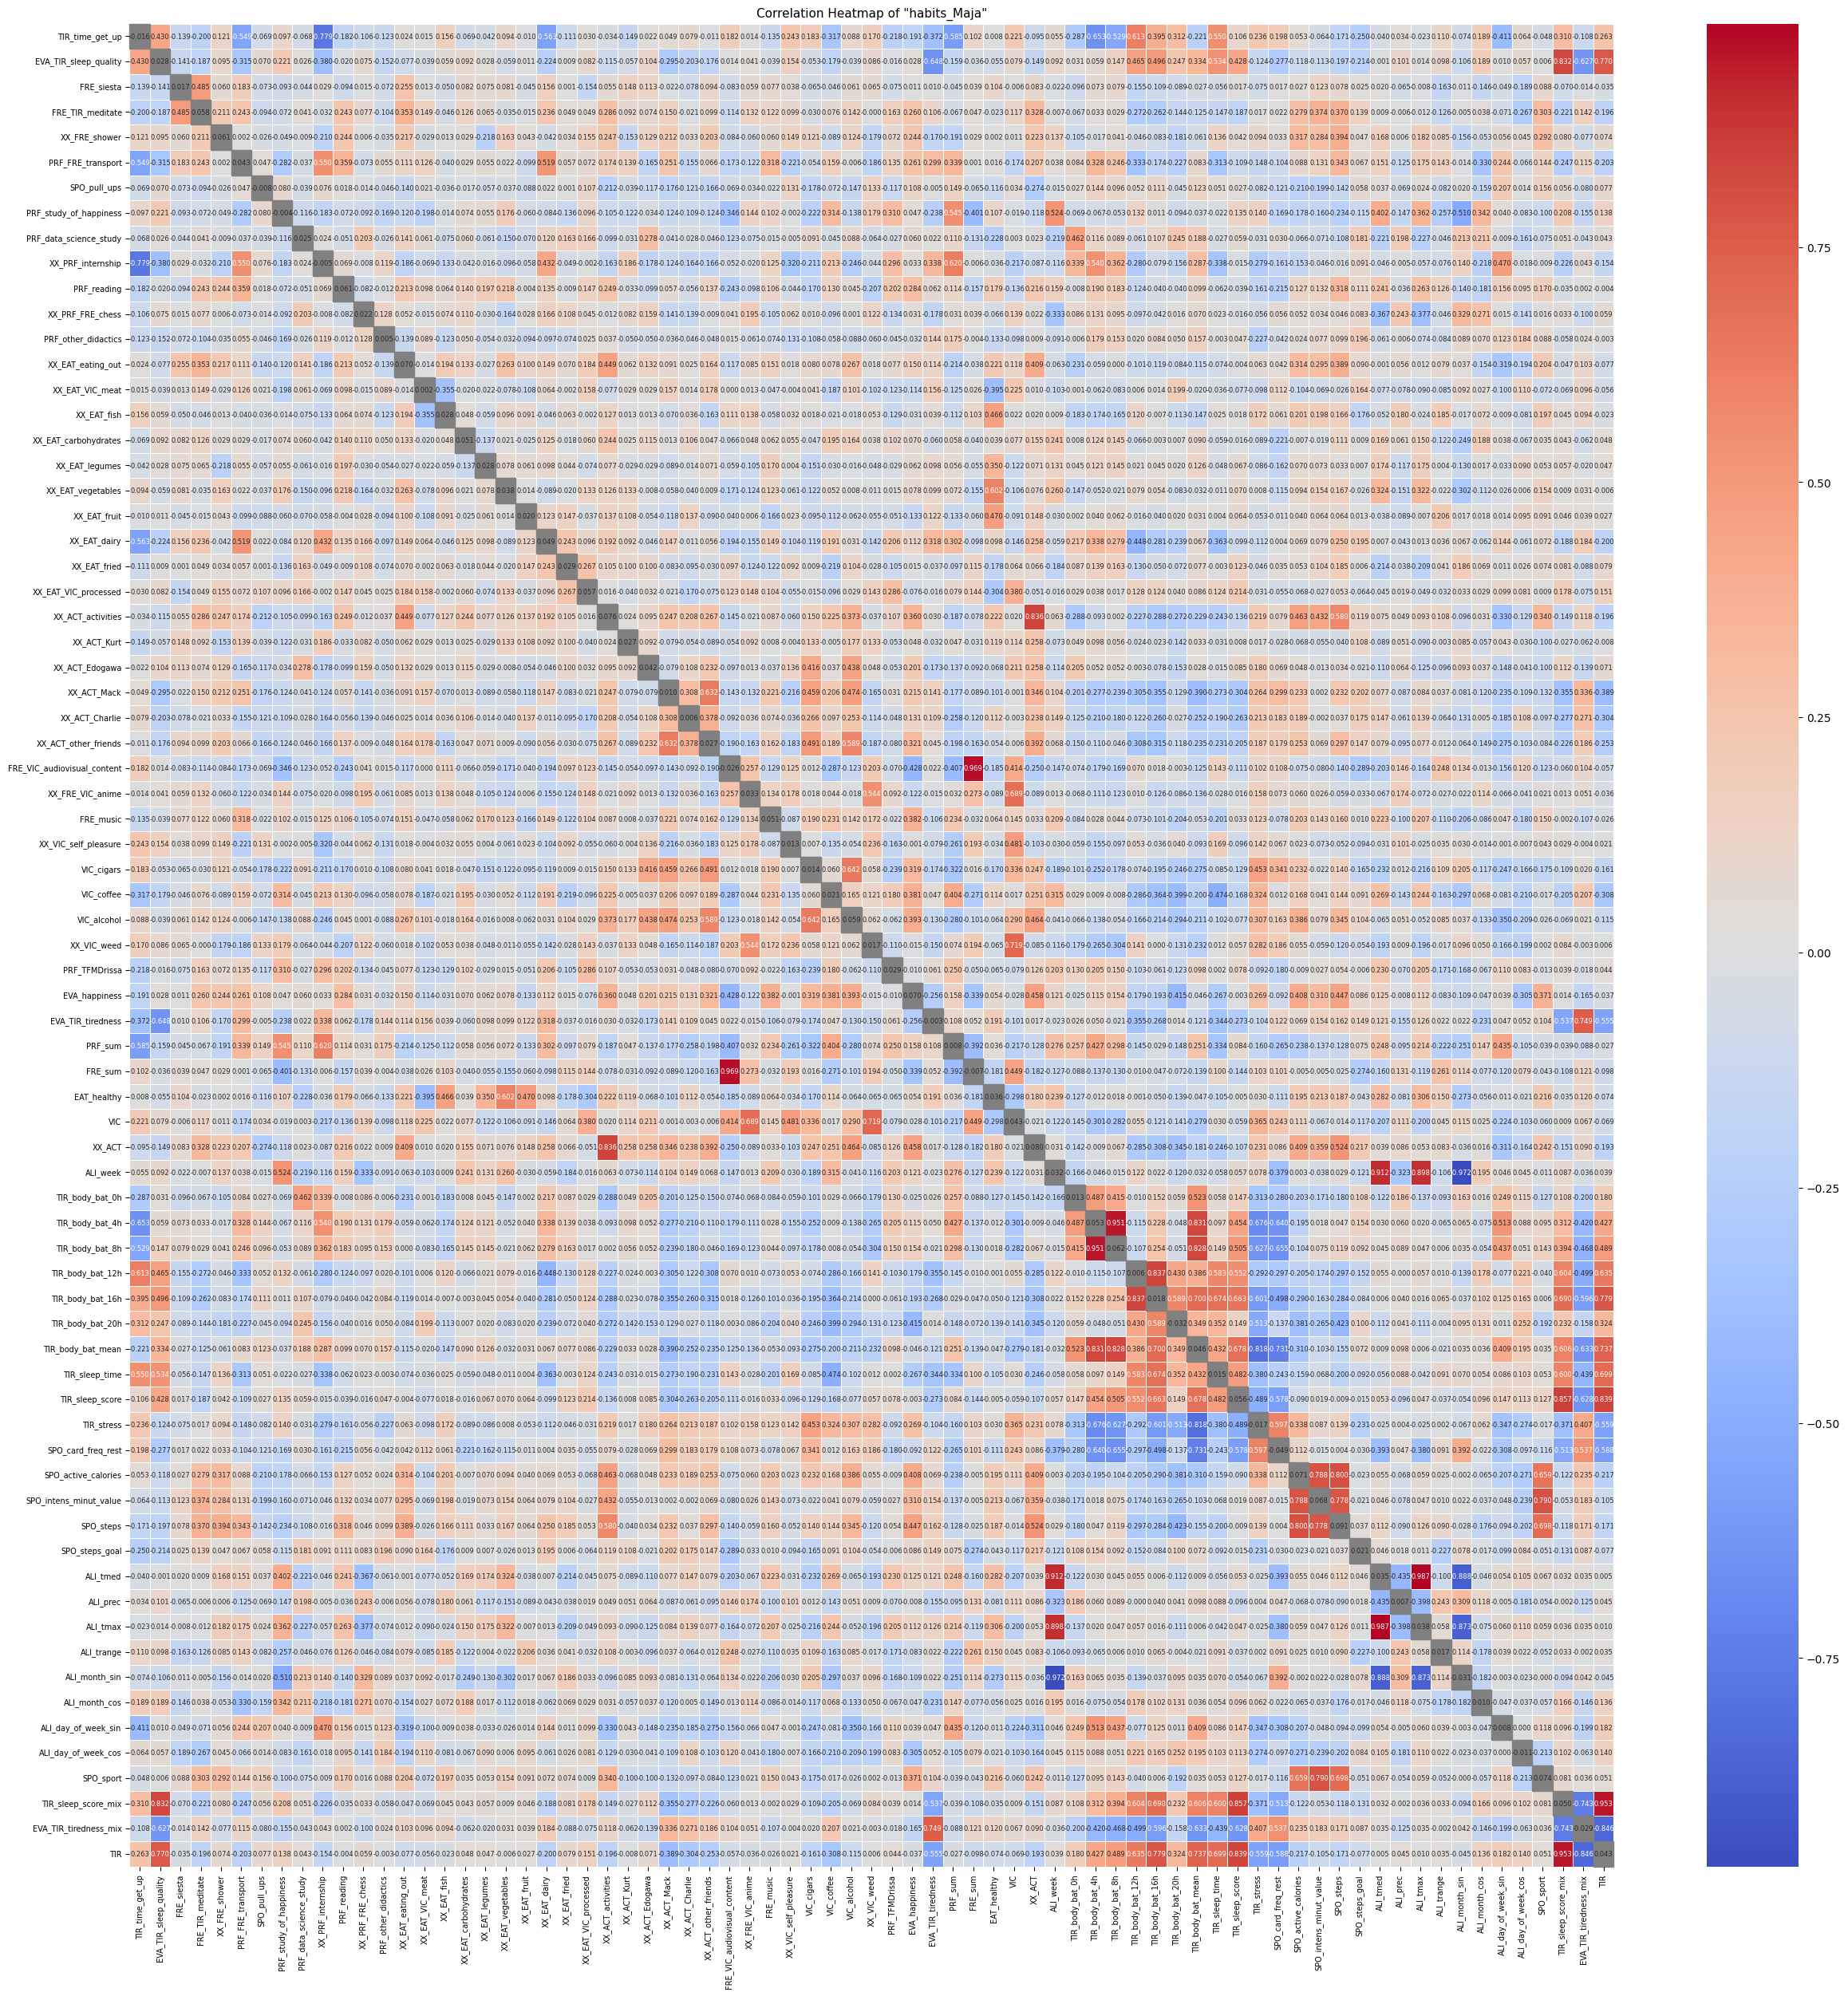

In [21]:
# Calculate the correlation matrix for the 'felicity' DataFrame
correlation_matrix = habits.corr()

# Get the column names to access the diagonal elements
column_names = correlation_matrix.columns

# Replace diagonal elements with the mean of the corresponding column
for col in column_names:
    correlation_matrix.loc[col, col] = correlation_matrix[col].mean()

# Set up the matplotlib figure
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed

# Create the heatmap using seaborn and store the return value in 'heatmap'
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)

# Change the font size of the annotations
for text in heatmap.texts:
    text.set_fontsize(6)  # Set the desired font size (e.g., 8)

# Get the diagonal indices
indices = np.arange(len(column_names))

# Highlight the diagonal cells with green color
for i in indices:
    heatmap.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='grey', clip_on=False))

# Change the font size of the axis labels (feature names)
plt.xticks(fontsize=7)  # Set the desired font size for x-axis labels (feature names)
plt.yticks(fontsize=7)  # Set the desired font size for y-axis labels (feature names)

plt.title('''Correlation Heatmap of "habits_Maja"''', fontsize=11)
plt.show()

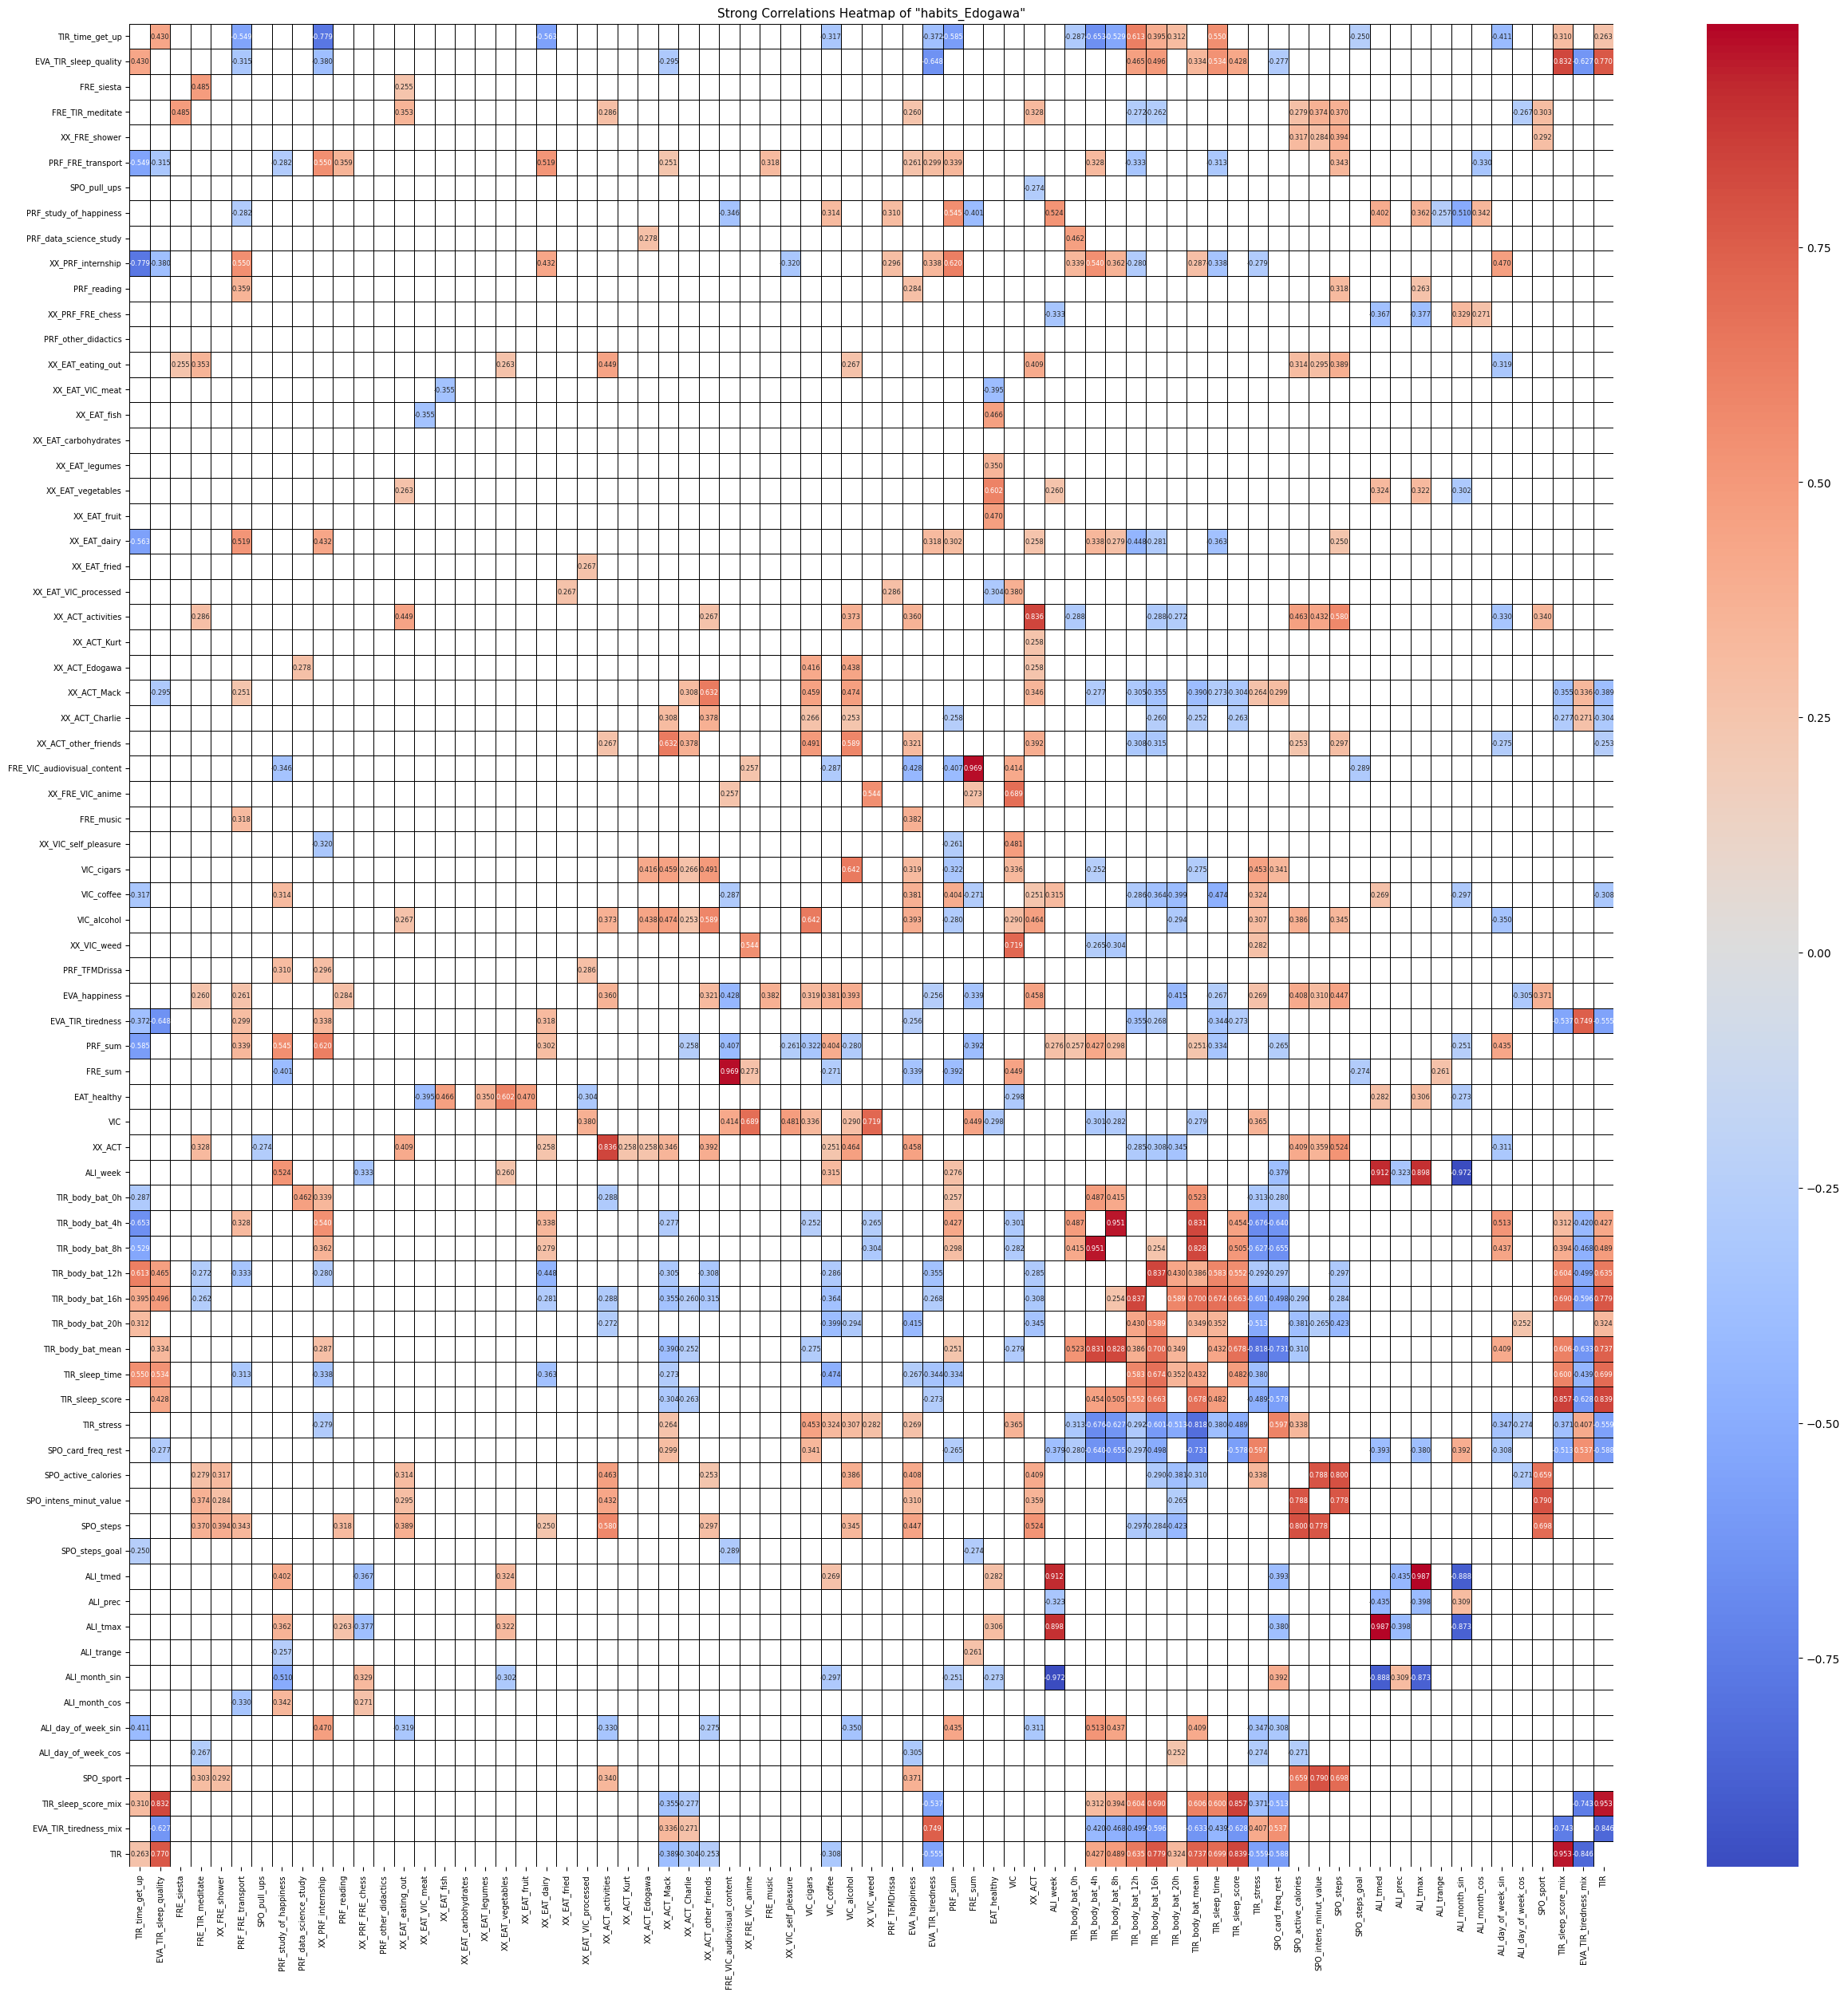

In [22]:
# Filter the correlation matrix to keep only strong correlations (> 0.25 and < -0.25)
strong_correlations = correlation_matrix[((correlation_matrix > 0.25) | (correlation_matrix < -0.25))]

# Check if any strong correlations exist
if strong_correlations.empty:
    print("No strong correlations found.")
else:
    # Set up the matplotlib figure
    plt.figure(figsize=(30, 30))  # Adjust the figure size as needed

    # Create the heatmap using seaborn and store the return value in 'heatmap'
    heatmap = sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5,linecolor='black',)

    # Change the font size of the annotations
    for text in heatmap.texts:
        text.set_fontsize(6)  # Set the desired font size (e.g., 8)

    # Change the font size of the axis labels (feature names)
    plt.xticks(fontsize=7)  # Set the desired font size for x-axis labels (feature names)
    plt.yticks(fontsize=7)  # Set the desired font size for y-axis labels (feature names)
    plt.title('''Strong Correlations Heatmap of "habits_Edogawa"''', fontsize=11)
    plt.show()

# Drop selectet strong correlated variables

Haciendo distintas iteraciones y evaluando cómo varía la suma de correlaciones en valor absoluto, decidimos eliminar las siguientes columnes:
- Como 'FRE_sum' es la suma de 'FRE_VIC_audiovisual_content' y 'FRE_VIC_SocialNetworks', eliminamos una des estas últimas. Eliminando 'FRE_VIC_SocialNetworks' se obtiene una mayor correlación absoluta.
- Del mismo modo, como 'XX_ACT', que es la suma de 'XX_ACT_Family' y 'XX_ACT_Friends', eliminamos  'XX_ACT_Friends'.
- Del mismo modo, como 'VIC' es la suma de diversas columnas, eliminamos la que nos hace obtener una mayor suma de correlaciones absolutas, 'FRE_VIC_audiovisual_content'

In [23]:
habits=habits.drop(columns=['XX_PRF_FRE_chess', 'PRF_FRE_transport', 'XX_ACT_other_friends', 'XX_EAT_carbohydrates', 'FRE_VIC_audiovisual_content', 'SPO_pull_ups', 'EVA_TIR_tiredness', 'XX_ACT_activities', 'TIR_time_get_up'])
#TIR_time_get_up

In [24]:
#split the data into features (X) and target variable (y)
X = habits.drop(columns=['EVA_happiness'])
y = habits["EVA_happiness"]

#Build a linear regression model
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor()

#train the model
linear_model.fit(X, y)
random_forest_model.fit(X, y)

#obtain the feature importance of the models
linear_feature_importance = linear_model.coef_
random_forest_feature_importance = random_forest_model.feature_importances_

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear_Importance": linear_feature_importance,
    "RF_Importance": random_forest_feature_importance
})

# Ordenar las características por importancia
feature_importance_df = feature_importance_df.sort_values(by="RF_Importance", ascending=False)

feature_importance_df.head()

,Feature,Linear_Importance,RF_Importance
41,TIR_body_bat_20h,-0.134610,0.097837
34,XX_ACT,0.334449,0.085757
31,FRE_sum,-4.409646,0.083454
23,FRE_music,0.270145,0.079052
61,EVA_TIR_tiredness_mix,-0.251920,0.061728


In [25]:
# linear_feature_importance to absolute value
linear_feature_importance_abs = abs(linear_feature_importance)
#build a dataframe with the absolute feature importance
linear_feature_importance_abs = pd.DataFrame({
    "Feature": X.columns,
    "Linear_Importance": linear_feature_importance_abs,
})
#soort by importance
linear_feature_importance_abs.sort_values(by="Linear_Importance", ascending=False, inplace=True)
#obtain the cumulative sum of the absolute importance
print(linear_feature_importance_abs['Linear_Importance'].sum())
linear_feature_importance_abs.head(8)

181.68323635561276


,Feature,Linear_Importance
33,VIC,18.760638
28,XX_VIC_weed,17.146310
53,ALI_tmax,15.029285
51,ALI_tmed,14.975793
22,XX_FRE_VIC_anime,14.279126
10,XX_EAT_VIC_meat,12.059211
17,XX_EAT_VIC_processed,11.770040
24,XX_VIC_self_pleasure,11.756728


# Models

## 6.1. Random Forest [mse= 0.41201005507125826, 100 iterations, 29s]

El 'neg_mean_squared_error' es equivalente al MSE (Mean Squared Error) con un signo negativo. La razón detrás de esto es que, por convención, scikit-learn espera que la métrica de puntuación sea mayor para indicar un mejor rendimiento del modelo.

In [26]:
#param_grid = {
#    'n_estimators': [100, 200, 300],#The number of trees in the forest
#    'criterion': ['squared_error'],#The function to measure the quality of a split
#    'max_depth': [None],#The maximum depth of the tree
#    'min_samples_split': [2, 4, 6],#20, 50 #The minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 3],#The minimum number of samples required to be at a leaf node
#    'min_weight_fraction_leaf': [0.0, 0.000001, 0.00001],#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
#    'max_features': ['sqrt', 'log2', None],#The number of features to consider when looking for the best split
#    'max_leaf_nodes': [None],#Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#    'min_impurity_decrease': [0.0, 0.000001, 0.00001, 0.0001],#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
#    'bootstrap': [True, False],#If False, the whole dataset is used to build each tree.
#    'oob_score': [False],#Whether to use out-of-bag samples to estimate the generalization accuracy.
#    'n_jobs': [-1],#The number of jobs to run in parallel for both fit and predict.
#    'random_state': [42],#Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
#    'ccp_alpha': [0.0, 0.0005, 0.001, 0.005],#Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
##    'max_samples': [None],#If bootstrap is True, the number of samples to draw from X to train each base estimator.
#}#16m
#Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.001, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 1e-06, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42}
#Best score: -1.2869864695963207

In [27]:
#param_grid = {
#    'n_estimators': [200],#The number of trees in the forest
#    'criterion': ['squared_error'],#The function to measure the quality of a split
#    'max_depth': [None],#The maximum depth of the tree
#    'min_samples_split': [2, 3, 4, 5, 6, 8],#20, 50 #The minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 3, 4],#The minimum number of samples required to be at a leaf node
#    'min_weight_fraction_leaf': [0.0000001, 0.000001, 0.000002],#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
#    'max_features': ['sqrt', 'log2', None],#The number of features to consider when looking for the best split
#    'max_leaf_nodes': [None],#Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#    'min_impurity_decrease': [0.0, 0.0000001, 0.01],#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
#    'bootstrap': [True, False],#If False, the whole dataset is used to build each tree.
#    'oob_score': [False],#Whether to use out-of-bag samples to estimate the generalization accuracy.
#    'n_jobs': [-1],#The number of jobs to run in parallel for both fit and predict.
#    'random_state': [42],#Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
#    'warm_start': [True, False],#When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
#    'ccp_alpha': [0.0, 0.00075, 0.001, 0.002],#Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
##    'max_samples': [None],#If bootstrap is True, the number of samples to draw from X to train each base estimator.
#}#23m
#Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.001, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 1e-07, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': False}
#Best score: -1.2869864695963207

In [28]:
#param_grid = {
#    'n_estimators': [200],#The number of trees in the forest
#    'criterion': ['squared_error'],#The function to measure the quality of a split
#    'max_depth': [None],#The maximum depth of the tree
#    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],#20, 50 #The minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 3, 4, 5],#The minimum number of samples required to be at a leaf node
#    'min_weight_fraction_leaf': [0.0, 0.00000001, 0.0000001, 0.000001],#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
#    'max_features': ['sqrt'],#The number of features to consider when looking for the best split
#    'max_leaf_nodes': [None],#Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#    'min_impurity_decrease': [0.0],#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
#    'bootstrap': [False],#If False, the whole dataset is used to build each tree.
#    'oob_score': [False],#Whether to use out-of-bag samples to estimate the generalization accuracy.
#    'n_jobs': [-1],#The number of jobs to run in parallel for both fit and predict.
#    'random_state': [42],#Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
#    'warm_start': [True, False],#When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
#    'ccp_alpha': [0.0001, 0.0009, 0.001, 0.0015],#Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
##    'max_samples': [None],#If bootstrap is True, the number of samples to draw from X to train each base estimator.
#}
#Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0001, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': True}
#Best score: -1.2869571735042962

In [29]:
#param_grid = {
#    'n_estimators': [200],#The number of trees in the forest
#    'criterion': ['squared_error'],#The function to measure the quality of a split
#    'max_depth': [None, 1, 3, 5],#The maximum depth of the tree
#    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],#20, 50 #The minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 3, 4, 5],#The minimum number of samples required to be at a leaf node
#    'min_weight_fraction_leaf': [0.0, 0.00000001, 0.0000001, 0.000001],#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
#    'max_features': ['sqrt'],#The number of features to consider when looking for the best split
#    'max_leaf_nodes': [None],#Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#    'min_impurity_decrease': [0.0],#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
#    'bootstrap': [False],#If False, the whole dataset is used to build each tree.
#    'oob_score': [False],#Whether to use out-of-bag samples to estimate the generalization accuracy.
#    'n_jobs': [-1],#The number of jobs to run in parallel for both fit and predict.
#    'random_state': [42],#Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
#    'warm_start': [True, False],#When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
#    'ccp_alpha': [0.00001, 0.0001, 0.001],#Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
##    'max_samples': [None],#If bootstrap is True, the number of samples to draw from X to train each base estimator.
#}#4m
#Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0001, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 10, 'min_weight_fraction_leaf': 1e-07, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': False}
#Best score: -1.2486215960644163

#Best Parameters: {'bootstrap': False, 'ccp_alpha': 1e-05, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': False}
#Best score: -1.2435921726466042

In [30]:
#param_grid = {
#    'n_estimators': [200],#The number of trees in the forest
#    'criterion': ['squared_error'],#The function to measure the quality of a split
#    'max_depth': [None],#The maximum depth of the tree
#    'min_samples_split': [2, 3, 4, 5, 6, 8, 10],#20, 50 #The minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 3, 4, 5],#The minimum number of samples required to be at a leaf node
#    'min_weight_fraction_leaf': [0.0, 0.00000001],#The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node
#    'max_features': ['sqrt', 'log2', None],#The number of features to consider when looking for the best split
#    'max_leaf_nodes': [None],#Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
#    'min_impurity_decrease': [0.0, 0.0001],#A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
#    'bootstrap': [True, False],#If False, the whole dataset is used to build each tree.
#    'oob_score': [False],#Whether to use out-of-bag samples to estimate the generalization accuracy.
#    'n_jobs': [-1],#The number of jobs to run in parallel for both fit and predict.
#    'random_state': [42],#Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
#    'warm_start': [True, False],#When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
#    'ccp_alpha': [0.0, 0.000001, 0.00001],#Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
##    'max_samples': [None],#If bootstrap is True, the number of samples to draw from X to train each base estimator.
#}#65m
#Best Parameters: {'bootstrap': True, 'ccp_alpha': 1e-05, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'warm_start': False}
#Best score: -1.237487777798087

In [31]:
## Create a Random Forest regressor instance
#rf_regressor = RandomForestRegressor()
#
## Create GridSearchCV instance
#grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
#                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
#
## Fit the grid search to your data
#grid_search.fit(X, y)
#
## Print the best parameters found by GridSearch
#print("#Best Parameters:", grid_search.best_params_)
#print("#Best score:", grid_search.best_score_)

El Error Cuadrado Medio (MSE por sus siglas en inglés, Mean Squared Error) es una medida común de la calidad de un modelo de regresión. Proporciona una idea de qué tan cerca están las predicciones del modelo de los valores reales en términos de sus diferencias cuadradas.
- El Error Cuadrado Medio (MSE por sus siglas en inglés, Mean Squared Error) es una medida común de la calidad de un modelo de regresión. Proporciona una idea de qué tan cerca están las predicciones del modelo de los valores reales en términos de sus diferencias cuadradas.
- Un valor de MSE más alto indica que las predicciones del modelo están más lejos de los valores reales. Esto podría ser el resultado de un modelo que no está ajustando bien los datos o que está siendo afectado por el ruido en los datos.
- El MSE es sensible a valores atípicos, ya que toma las diferencias al cuadrado. Por lo tanto, los valores atípicos pueden tener un impacto significativo en el valor total del MSE.

El MSE mide el promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. Un valor menor indica un mejor ajuste del modelo.

En cambio, Coeficiente de Determinación (R2): También conocido como el coeficiente de determinación, R2 proporciona una medida de cuánta variabilidad en la variable objetivo es explicada por el modelo. R2 se encuentra entre 0 y 1, y un valor más cercano a 1 indica un mejor ajuste.



Si deseas mantener un enfoque coherente en términos de métrica de puntuación, puedes usar 'neg_mean_squared_error' para los criterios que estén relacionados con MSE (por ejemplo, 'squared_error' y 'friedman_mse'), ya que el valor negativo de MSE será una métrica de puntuación más grande (mayor es mejor) y coherente con la búsqueda de GridSearch.

Si tienes un criterio que no está relacionado con MSE (por ejemplo, 'absolute_error' o 'poisson'), deberías cambiar la métrica de puntuación en consecuencia. Por ejemplo, podrías usar 'neg_mean_absolute_error' para el criterio de error absoluto o algún otro que se ajuste a la métrica específica que deseas optimizar.



In [32]:
# Define the number of iterations and the number of splits in the cross-validation
num_iterations = 100
num_splits = 3

# Lists to store the results of feature importance and model performance
feature_importances_list = []
mse_RF = []

# Train and evaluate the model in each iteration
for iteration in range(num_iterations):
    # Split the data into training and test sets using cross-validation
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=iteration)
    feature_importances_iteration = []
    mse_iteration = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Build a Random Forest regressor with the best parameters found
        rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.00001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)


        # Train the model
        rf.fit(X_train, y_train)
        
        # Obtaining the feature importance
        feature_importances_iteration.append(rf.feature_importances_)#importancia de características por cada fold de la última iteración
        
        # Make predictions on the test set and calculate the mean squared error
        y_pred = rf.predict(X_test)#predicciones hechas por la última iteración
        mse_iteration.append(mean_squared_error(y_test, y_pred))#error por cada fold de la última iteración
    
    # Calculate the mean of feature importance and mean squared error in each iteration
    feature_importances_mean = np.mean(feature_importances_iteration, axis=0)# promedio de importancia de cada feature por cada fold de la última iteración
    mse_mean = np.mean(mse_iteration)# promedio de errores por cada fold de la última iteración
    
    # Store the results in the lists
    feature_importances_list.append(feature_importances_mean)#acumula los promedios de importancia de cada feature por cada fold de todas las iteraciones
    mse_RF.append(mse_mean)#acumula los promedio de errores por cada fold de todas las iteraciones

# Find the weights according to the mean squared error
weights = [1 / mse for mse in mse_RF]
# Normaliza los pesos para que sumen 1
weights_RF = [weight / sum(weights) for weight in weights]

# Calculate the weighted feature importance
feature_importances_weighted = np.average(feature_importances_list, axis=0, weights=weights_RF)

# Build the final DataFrame with the features and their importance
importance_RF = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_weighted})

# Results
mse_mean_RF = np.mean(mse_RF)
print("#Mean Squared Error (Random Forest mse):", mse_mean_RF)
print("Sum of Importance:", importance_RF['Importance'].sum())
print("Feature Importance:")
print(importance_RF)

##############################################################################################################
##############################################################################################################
#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.00001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.001, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1366192640175259
#100 iterations 1m
##############################################################################################################
##############################################################################################################

#rf=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1, oob_score=True, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1808411706752096

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=1e-06, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration)
#Mean Squared Error (Random Forest mse): 1.1343593749006926

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=1e-07, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1343593749006926

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=True)
#Mean Squared Error (Random Forest mse): 1.136416521767763

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf=1e-07, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1687050206022445

##############################################################################################################

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=3, min_samples_split=10, min_weight_fraction_leaf=1e-07, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.168400300219879

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.00001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.142656611790213

#rf=RandomForestRegressor(bootstrap=True, ccp_alpha=0.00001, criterion='squared_error', max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=2, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1791438260313643

##############################################################################################################

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=1e-07, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.1367615414556196
#Mean Squared Error (Random Forest mse): 1.1397856766636953

#rf=RandomForestRegressor(bootstrap=False, ccp_alpha=0.0001, criterion='squared_error', max_depth=None, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.00001, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=1e-07, n_estimators=200, n_jobs=-1, oob_score=False, random_state=iteration, warm_start=False)
#Mean Squared Error (Random Forest mse): 1.139696239025021


#Mean Squared Error (Random Forest mse): 1.1366192640175259
Sum of Importance: 0.9999999999999999
Feature Importance:
                   Feature  Importance
0    EVA_TIR_sleep_quality    0.009711
1               FRE_siesta    0.002698
2         FRE_TIR_meditate    0.006699
3            XX_FRE_shower    0.004918
4   PRF_study_of_happiness    0.017562
..                     ...         ...
58     ALI_day_of_week_cos    0.013039
59               SPO_sport    0.036020
60     TIR_sleep_score_mix    0.018743
61   EVA_TIR_tiredness_mix    0.038411
62                     TIR    0.022278

[63 rows x 2 columns]


## 6.2. Gradient Boosting [mse=0.47311289100878234, 200 iterations, 29s]

El parámetro loss determina la función de pérdida que se utilizará para optimizar el modelo. En este caso, quieres minimizar el error cuadrado medio (MSE), por lo que 'squared_error' es la opción adecuada.

En el contexto de Gradient Boosting, criterion define la función de costo que se utiliza para evaluar la calidad de una división en los nodos durante la construcción del árbol. En este caso, a pesar de que friedman_mse esta optimizada para Gradient Boosting, puesto que usamos 'squared_error' para loss, usaremos también 'squared_error' para criterion.

In [33]:
#param_grid = {
#    'loss': ['squared_error'],
#    'learning_rate': [0.15, 0.2, 0.3],
#    'n_estimators': [75, 100, 150],
#    'subsample': [0.5, 0.6, 0.7, 1.0],
#    'criterion': ['squared_error'],
#    'min_samples_split': [2, 3, 4, 5],
#    'min_samples_leaf': [1, 2, 3, 4, 5],
#    'min_weight_fraction_leaf': [0.0, 0.0001],
#    'min_impurity_decrease': [0.0, 0.005, 0.01, 0.05],
#    'init': [None, 'zero'],
#    'random_state': [42],
#    'max_features': ['sqrt', 'log2', None],
#}# 34560 parameter combinations 11m
#Best Parameters: {'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.15, 'loss': 'squared_error', 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'random_state': 42, 'subsample': 0.7}
#Best MSE Score: 1.1267987429097668

#param_grid = {
#    'loss': ['squared_error'],
#    'learning_rate': [0.05, 0.1, 0.15],
#    'n_estimators': [150, 200, 300],
#    'subsample': [ 0.7, 0.8, 0.9, 1.0],
#    'criterion': ['squared_error'],
#    'min_samples_split': [2, 3, 4, 5],
#    'min_samples_leaf': [1, 2, 3, 4, 5],
#    'min_weight_fraction_leaf': [0.0, 0.000001],
#    'min_impurity_decrease': [0.0, 0.00001, 0.0001],
#    'init': [None, 'zero'],
#    'random_state': [42],
#    'max_features': ['sqrt', 'log2', None],
#    'validation_fraction': [0.01, 0.1, 0.5],
#    'tol': [0.0, 0.0001, 0.01],
#}#233280 parameter combinations 278m
#Best Parameters: {'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_features': 'log2', 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.7, 'tol': 0.0, 'validation_fraction': 0.01}
#Best MSE Score: 1.1001472894574758

#param_grid = {
#    'loss': ['squared_error'],
#    'learning_rate': [0.075, 0.1, 0.125],
#    'n_estimators': [200],
#    'subsample': [0.65, 0.7, 0.75],
#    'criterion': ['squared_error'],
#    'min_samples_split': [2, 3, 4, 5],
#    'min_samples_leaf': [1, 2, 3, 4],
#    'min_weight_fraction_leaf': [0.0],
#    'min_impurity_decrease': [0.0, 0.0001],
#    'init': ['zero'],
#    'random_state': [42],
#    'max_features': ['sqrt', 'log2', None],
#    'max_depth': [3, 5, None],
#    'max_leaf_nodes': [None],
#    'warm_start': [False, True],
#    'validation_fraction': [0.001, 0.01],
#    'tol': [0.0],
#}#11m
#Best Parameters: {'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.7, 'tol': 0.0, 'validation_fraction': 0.001, 'warm_start': False}
#Best MSE Score: 0.9944945177068371

#param_grid = {
#    'loss': ['squared_error'],
#    'learning_rate': [0.1],
#    'n_estimators': [200],
#    'subsample': [0.65, 0.7, 0.75],
#    'criterion': ['squared_error'],
#    'min_samples_split': [2, 3, 4, 5],
#    'min_samples_leaf': [1, 2, 3, 4],
#    'min_weight_fraction_leaf': [0.0],
#    'min_impurity_decrease': [0.0],
#    'init': ['zero'],
#    'random_state': [42],
#    'max_features': ['sqrt', 'log2', None],
#    'max_depth': [3, 5, None],
#    'max_leaf_nodes': [None],
#    'warm_start': [False, True],
#    'validation_fraction': [0.001, 0.01],
#    'n_iter_no_change': [None, 5, 10],
#    'tol': [0.0],
#    'ccp_alpha': [0.0, 0.0001, 0.001]
#}#9m
#Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7, 'tol': 0.0, 'validation_fraction': 0.001, 'warm_start': False}
#Best MSE Score: 0.9944945177068371

#Best Parameters: {'ccp_alpha': 0.001, 'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7, 'tol': 0.0, 'validation_fraction': 0.001, 'warm_start': False}
#Best MSE Score: 0.9890588064392617

In [34]:
#param_grid = {
#    'loss': ['squared_error'],
#    'learning_rate': [0.05, 0.1, 0.2],
#    'n_estimators': [200],
#    'subsample': [0.65, 0.7, 0.75],
#    'criterion': ['squared_error'],
#    'min_samples_split': [2, 3, 4],
#    'min_samples_leaf': [1, 2, 3],
#    'min_weight_fraction_leaf': [0.0],
#    'min_impurity_decrease': [0.0],
#    'init': ['zero', None],
#    'random_state': [42],
#    'max_features': ['sqrt', 'log2', None],
#    'max_depth': [3, None],
#    'max_leaf_nodes': [None],
#    'warm_start': [False, True],
#    'validation_fraction': [0.0001, 0.001],
#    'n_iter_no_change': [None, 20],
#    'tol': [0.0],
#    'ccp_alpha': [0.0005, 0.001, 0.01]
#}
#Best Parameters: {'ccp_alpha': 0.001, 'criterion': 'squared_error', 'init': 'zero', 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7, 'tol': 0.0, 'validation_fraction': 0.0001, 'warm_start': False}
#Best MSE Score: 0.9890588064392617

In [35]:
## Create the Gradient Boosting regressor
#gb = GradientBoostingRegressor()
#
## Create the GridSearchCV object with cross-validation
#grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
#
## Fit the GridSearchCV object to your data
#grid_search.fit(X, y)
#
## Print the best parameters and corresponding MSE score
#print("#Best Parameters:", grid_search.best_params_)
#print("#Best MSE Score:", -grid_search.best_score_)

In [36]:
# Define the number of iterations and the number of splits in the cross-validation
num_iterations = 200
num_splits = 3

# Lists to store the results of feature importance and model performance
feature_importances_list = []
mse_GB = []

# Train and evaluate the model in each iteration
for iteration in range(num_iterations):
    # Split the data into training and test sets using cross-validation
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=iteration)
    feature_importances_iteration = []
    mse_iteration = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Build a Gradient Boosting regressor with the best parameters found
        gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.01, n_estimators=200, random_state=iteration, subsample=0.6, tol=0.0, validation_fraction=0.01)

        # Train the model
        gb.fit(X_train, y_train)
        
        # Obtaining the feature importance
        feature_importances_iteration.append(gb.feature_importances_)
        
        # Make predictions on the test set and calculate the mean squared error
        y_pred = gb.predict(X_test)
        mse_iteration.append(mean_squared_error(y_test, y_pred))
    
    # Calculate the mean of feature importance and mean squared error in each iteration
    feature_importances_mean = np.mean(feature_importances_iteration, axis=0)
    mse_mean = np.mean(mse_iteration)
    
    # Store the results in the lists
    feature_importances_list.append(feature_importances_mean)
    mse_GB.append(mse_mean)

# Find the weights according to the mean squared error
weights = [1 / mse for mse in mse_GB]
# Normalize the weights to sum up to 1
weights_GB = [weight / sum(weights) for weight in weights]

# Calculate the weighted feature importance
feature_importances_weighted = np.average(feature_importances_list, axis=0, weights=weights_GB)

# Build the final DataFrame with the features and their importance
importance_GB = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_weighted})

# Results
mse_mean_GB = np.mean(mse_GB)
print("#Mean Squared Error (Gradient Boosting mse):", mse_mean_GB)
print("Sum of Importance:", importance_GB['Importance'].sum())
print("Feature Importance:")
print(importance_GB)

##############################################################################################################
##############################################################################################################
#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.01, n_estimators=200, random_state=iteration, subsample=0.6, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 0.9933244855139083
#200 iterations 1m
##############################################################################################################
##############################################################################################################

#gb=GradientBoostingRegressor(ccp_alpha=0.0, criterion='squared_error', init='zero', learning_rate=0.4, loss='squared_error', max_depth=3, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=5e-05, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.0001, warm_start=False)
#Mean Squared Error (Gradient Boosting mse): 1.3468959792184894

#gb=GradientBoostingRegressor(criterion='squared_error', init='zero', learning_rate=0.15, loss='squared_error', max_features='sqrt', min_impurity_decrease=0.0, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=150, random_state=iteration, subsample=0.7)
#Mean Squared Error (Gradient Boosting mse): 1.0815516781148515

#gb=GradientBoostingRegressor(criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_features='log2', min_impurity_decrease=0.0001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.0435210756139939

#gb=GradientBoostingRegressor(criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.001, warm_start=False)
#Mean Squared Error (Gradient Boosting mse): 1.0784548858817433

#gb=GradientBoostingRegressor(ccp_alpha=0.0, criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200, n_iter_no_change=None, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.001, warm_start=False)
#Mean Squared Error (Gradient Boosting mse): 1.0784548858817433

##############################################################################################################

#gb=GradientBoostingRegressor(ccp_alpha=0.0, criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200, n_iter_no_change=None, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.001, warm_start=False)
#Mean Squared Error (Gradient Boosting mse): 1.068419417989654

#gb=GradientBoostingRegressor(ccp_alpha=0.001, criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_depth=3, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200, n_iter_no_change=None, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.001, warm_start=False)
#Mean Squared Error (Gradient Boosting mse): 1.0711876700917458

##############################################################################################################

#gb=GradientBoostingRegressor(criterion='squared_error', init='zero', learning_rate=0.1, loss='squared_error', max_features='log2', min_impurity_decrease=0.0001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.0542057540216385

#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.1, loss='squared_error', max_features='log2', min_impurity_decrease=0.0001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.053127912165765

#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.0001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.0172797533193816

#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.001, min_samples_leaf=2, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.0171684176006495

#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200, random_state=iteration, subsample=0.7, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 1.0079676039321404

#gb=GradientBoostingRegressor(criterion='squared_error', init=None, learning_rate=0.05, loss='squared_error', max_features='log2', min_impurity_decrease=0.001, min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.01, n_estimators=200, random_state=iteration, subsample=0.6, tol=0.0, validation_fraction=0.01)
#Mean Squared Error (Gradient Boosting mse): 0.9996075517216301


#Mean Squared Error (Gradient Boosting mse): 0.9933244855139083
Sum of Importance: 1.0000000000000002
Feature Importance:
                   Feature  Importance
0    EVA_TIR_sleep_quality    0.010803
1               FRE_siesta    0.002322
2         FRE_TIR_meditate    0.006856
3            XX_FRE_shower    0.008242
4   PRF_study_of_happiness    0.020948
..                     ...         ...
58     ALI_day_of_week_cos    0.015752
59               SPO_sport    0.033004
60     TIR_sleep_score_mix    0.021385
61   EVA_TIR_tiredness_mix    0.046648
62                     TIR    0.025997

[63 rows x 2 columns]


## 6.3. XGBoost [mse= 0.4049255296114228, 400 iterations, 40s]

In [37]:
#param_grid = {
#    'booster': ['gbtree', 'gblinear', 'dart'],#which booster to use
#    'learning_rate': [0.1, 0.2, 0.3],#step size shrinkage used in update to prevents overfitting
#    'min_child_weight': [1, 3, 5],#minimum sum of instance weight (hessian) needed in a child
#    'subsample': [0.5, 0.7, 0.9],#subsample ratio of the training instance
#    'colsample_bytree': [0.5, 0.7, 0.9],#subsample ratio of columns when constructing each tree
#    'colsample_bylevel': [0.5, 0.7, 0.9],#subsample ratio of columns for each split, in each level
#    'colsample_bynode': [0.5, 0.7, 0.9],#subsample ratio of columns for each node (split)
#    'reg_lambda': [0, 0.5, 1, 2],#L2 regularization term on weights
#    'alpha': [0, 0.5, 1, 2],#L1 regularization term on weights
#}#10m 30s
#Best Parameters: {'alpha': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 5, 'reg_lambda': 0.5, 'subsample': 0.5}
#Best MSE Score: 1.0118348152466903


In [38]:
#param_grid = {
#    'booster': ['gbtree'],#which booster to use
#    'learning_rate': [0.01, 0.05, 0.1],#step size shrinkage used in update to prevents overfitting
#    'min_child_weight': [2, 4, 5, 6],#minimum sum of instance weight (hessian) needed in a child
#    'subsample': [0.5, 0.7, 0.9],#subsample ratio of the training instance
#    'colsample_bytree': [0.8, 0.9, 0.95],#subsample ratio of columns when constructing each tree
#    'colsample_bylevel': [0.4, 0.5, 0.6],#subsample ratio of columns for each split, in each level
#    'colsample_bynode': [0.8, 0.9, 0.95],#subsample ratio of columns for each node (split)
#    'reg_lambda': [0.25, 0.5, 0.75, 3],#L2 regularization term on weights
#    'alpha': [0.25, 0.5, 0.75, 3],#L1 regularization term on weights
#    'refresh_leaf': [0, 1],#whether to refresh leafs
#}#9m
#Best Parameters: {'alpha': 0.25, 'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 0.9, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 6, 'refresh_leaf': 0, 'reg_lambda': 0.5, 'subsample': 0.5}
#Best MSE Score: 0.9855679771836362

In [39]:
#param_grid = {
#    'booster': ['gbtree'],#which booster to use
#    'learning_rate': [0.075, 0.1, 0.15],#step size shrinkage used in update to prevents overfitting
#    'max_depth': [6, 9, None],#maximum depth of a tree
#    'max_delta_step': [0, 1],#maximum delta step we allow each tree's weight estimation to be
#    'min_child_weight': [5, 6, 10],#minimum sum of instance weight (hessian) needed in a child
#    'subsample': [0.4, 0.5, 0.6],#subsample ratio of the training instance
#    'colsample_bytree': [0.75, 0.8, 0.85, 0.9],#subsample ratio of columns when constructing each tree
#    'colsample_bylevel': [0.45, 0.5, 0.55],#subsample ratio of columns for each split, in each level
#    'colsample_bynode': [0.85, 0.9],#subsample ratio of columns for each node (split)
#    'reg_lambda': [0.3, 0.5, 0.7],#L2 regularization term on weights
#    'alpha': [0.1, 0.25, 0.5],#L1 regularization term on weights
#    'scale_pos_weight': [0, 0.0001],#control the balance of positive and negative weights
#    'refresh_leaf': [0, 1],#whether to refresh leafs
#}#31m
#Best Parameters: {'alpha': 0.1, 'booster': 'gbtree', 'colsample_bylevel': 0.55, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 5, 'refresh_leaf': 0, 'reg_lambda': 0.7, 'scale_pos_weight': 0, 'subsample': 0.4}
#Best MSE Score: 0.9812534353300778

#Best Parameters: {'alpha': 0.1, 'booster': 'gbtree', 'colsample_bylevel': 0.55, 'colsample_bynode': 0.85, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 5, 'refresh_leaf': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 0, 'subsample': 0.6}
#Best MSE Score: 0.9467300779279967

In [40]:
#param_grid = {
#    'booster': ['gbtree'],#which booster to use
#    'learning_rate': [0.09, 0.1, 0.125],#step size shrinkage used in update to prevents overfitting
#    'max_depth': [6, 9, None],#maximum depth of a tree
#    'max_delta_step': [0],#maximum delta step we allow each tree's weight estimation to be
#    'min_child_weight': [3, 4, 5, 7],#minimum sum of instance weight (hessian) needed in a child
#    'subsample': [0.6, 0.7, 0.8],#subsample ratio of the training instance
#    'colsample_bytree': [0.85, 0.9, 0.95],#subsample ratio of columns when constructing each tree
#    'colsample_bylevel': [0.5, 0.55, 0.6],#subsample ratio of columns for each split, in each level
#    'colsample_bynode': [0.8, 0.85],#subsample ratio of columns for each node (split)
#    'reg_lambda': [0.4, 0.5, 0.6, 3],#L2 regularization term on weights
#    'alpha': [0.01, 0.1, 3],#L1 regularization term on weights
#    'scale_pos_weight': [0, 0.000001],#control the balance of positive and negative weights
#    'refresh_leaf': [0, 1],#whether to refresh leafs
#}
#Best Parameters: {'alpha': 0.1, 'booster': 'gbtree', 'colsample_bylevel': 0.55, 'colsample_bynode': 0.85, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 5, 'refresh_leaf': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 0, 'subsample': 0.6}
#Best MSE Score: 0.9467300779279967

In [41]:
## Create the Gradient Boosting regressor
#xgb = XGBRegressor()
#
## Create the GridSearchCV object with cross-validation
#grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
#
## Fit the GridSearchCV object to your data
#grid_search.fit(X, y)
#
#
## Print the best parameters and corresponding MSE score
#print("#Best Parameters:", grid_search.best_params_)
#print("#Best MSE Score:", -grid_search.best_score_)

In [42]:
# Define the number of iterations and the number of splits in the cross-validation
num_iterations = 300
num_splits = 3

# Lists to store the results of feature importance and model performance
feature_importances_list = []
mse_XGB = []

# Train and evaluate the model in each iteration
for iteration in range(num_iterations):
    # Split the data into training and test sets using cross-validation
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=iteration)
    feature_importances_iteration = []
    mse_iteration = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Build an XGBoost regressor with the best parameters found
        xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=4, refresh_leaf=0, reg_lambda=0.001, scale_pos_weight=0, subsample=0.5, random_state=iteration)



        # Train the model
        xgb.fit(X_train, y_train)
        
        # Obtaining the feature importance
        feature_importances_iteration.append(xgb.feature_importances_)
        
        # Make predictions on the test set and calculate the mean squared error
        y_pred = xgb.predict(X_test)
        mse_iteration.append(mean_squared_error(y_test, y_pred))
    
    # Calculate the mean of feature importance and mean squared error in each iteration
    feature_importances_mean = np.mean(feature_importances_iteration, axis=0)
    mse_mean = np.mean(mse_iteration)
    
    # Store the results in the lists
    feature_importances_list.append(feature_importances_mean)
    mse_XGB.append(mse_mean)

# Find the weights according to the mean squared error
weights = [1 / mse for mse in mse_XGB]
# Normalize the weights to sum up to 1
weights_XGB = [weight / sum(weights) for weight in weights]

# Calculate the weighted feature importance
feature_importances_weighted = np.average(feature_importances_list, axis=0, weights=weights_XGB)

# Build the final DataFrame with the features and their importance
importance_XGB = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_weighted})

# Results
mse_mean_XGB = np.mean(mse_XGB)
print("#Mean Squared Error (XGBoost mse):", mse_mean_XGB)
print("Sum of Importance:", importance_XGB['Importance'].sum())
print("Feature Importance:")
print(importance_XGB)

##############################################################################################################
##############################################################################################################
#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=4, refresh_leaf=0, reg_lambda=0.001, scale_pos_weight=0, subsample=0.5, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0191630562726297
#300 iterations 54s
##############################################################################################################
##############################################################################################################

#xgb=XGBRegressor(alpha=2, booster='gbtree', colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5, learning_rate=0.35, max_delta_step=0, max_depth=6, min_child_weight=0.25, refresh_leaf=0, reg_lambda=3, scale_pos_weight=0, subsample=0.7, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.3207250643688702

#xgb=XGBRegressor(alpha=0.5, booster='gbtree', colsample_bylevel=0.5, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.1, min_child_weight=5, reg_lambda=0.5, subsample=0.5, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0869210480525993

#xgb=XGBRegressor(alpha=0.25, booster='gbtree', colsample_bylevel=0.5, colsample_bynode=0.9, colsample_bytree=0.8, learning_rate=0.1, min_child_weight=6, refresh_leaf=0, reg_lambda=0.5, subsample=0.5, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0731835422069178

#xgb=XGBRegressor(alpha=0.1, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=6, min_child_weight=5, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0660166867482643

##############################################################################################################

#xgb=XGBRegressor(alpha=0.1, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=6, min_child_weight=5, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0703725926244072

#xgb=XGBRegressor(alpha=0.1, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.85, colsample_bytree=0.9, learning_rate=0.1, max_delta_step=0, max_depth=9, min_child_weight=5, refresh_leaf=0, reg_lambda=0.5, scale_pos_weight=0, subsample=0.6, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0770155652108426

##############################################################################################################

#xgb=XGBRegressor(alpha=0.1, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=6, min_child_weight=5, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0703725926244072
#Mean Squared Error (XGBoost mse): 1.071615648043107

#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=6, min_child_weight=5, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0704856941192518

#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=5, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0650370704022996

#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=4, refresh_leaf=0, reg_lambda=0.7, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.061005879022201

#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=4, refresh_leaf=0, reg_lambda=0.001, scale_pos_weight=0, subsample=0.4, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0309141524374295

#xgb=XGBRegressor(alpha=0.2, booster='gbtree', colsample_bylevel=0.55, colsample_bynode=0.9, colsample_bytree=0.9, learning_rate=0.075, max_delta_step=0, max_depth=2, min_child_weight=4, refresh_leaf=0, reg_lambda=0.001, scale_pos_weight=0, subsample=0.5, random_state=iteration)
#Mean Squared Error (XGBoost mse): 1.0240144072701403


#Mean Squared Error (XGBoost mse): 1.0191630562726297
Sum of Importance: 0.999999999667501
Feature Importance:
                   Feature  Importance
0    EVA_TIR_sleep_quality    0.015372
1               FRE_siesta    0.007982
2         FRE_TIR_meditate    0.012818
3            XX_FRE_shower    0.015736
4   PRF_study_of_happiness    0.018352
..                     ...         ...
58     ALI_day_of_week_cos    0.021699
59               SPO_sport    0.037325
60     TIR_sleep_score_mix    0.017415
61   EVA_TIR_tiredness_mix    0.025790
62                     TIR    0.020152

[63 rows x 2 columns]


## 6.4. SVM [mse= 0.3968530625647952, 4000 iterations, 33s]

In [43]:
#param_grid = {
#    'kernel': ['linear'],
#    'tol': [0.00000001, 0.0000001, 0.0000005, 0.0000009, 0.000001, 0.000002, 0.000005, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.35, 0.37, 0.38, 0.39, 0.3,0.31, 0.32, 0.33, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#    'C': [0.0005, 0.00075, 0.001, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.003, 0.005, 0.0075, 0.01, 0.012, 0.013, 0.014, 0.015, 0.015, 0.017, 0.018, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 0.4, 0.5, 0.9, 1, 2, 3, 4, 5, 10],
#    'epsilon': [0.05, 0.075, 0.1, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.5, 2, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 15, 20],
#    'shrinking': [True, False],
#    'max_iter': [10000],
#}#2m 50s
#Best Parameters: {'C': 0.00075, 'epsilon': 0.5, 'kernel': 'linear', 'max_iter': 10000, 'shrinking': True, 'tol': 0.35}
#Best MSE Score: 1.4812618733365204

#param_grid = {
#    'kernel': ['linear'],
#    'tol': [0.00000001, 0.0000001, 0.0000005, 0.0000009, 0.000001, 0.000002, 0.000005, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.075, 0.1, 0.15, 0.2, 0.35, 0.37, 0.38, 0.39, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#    'C': [0.0001, 0.0007, 0.00075, 0.0008, 0.001, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.003, 0.005, 0.0075, 0.01, 0.012, 0.013, 0.014, 0.015, 0.015, 0.017, 0.018, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 0.4, 0.5, 0.9, 1, 2, 3, 4, 5, 10],
#    'epsilon': [0.05, 0.075, 0.1, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.5, 2, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 15, 20],
#    'shrinking': [True, False],
#    'max_iter': [10000],
#}#2m 50s
#Best Parameters: {'C': 0.0001, 'epsilon': 0.2, 'kernel': 'linear', 'max_iter': 10000, 'shrinking': True, 'tol': 0.075}
#Best MSE Score: 1.4666232780138728

#param_grid = {
#    'kernel': ['linear'],
#    'tol': [0.00000001, 0.0000001, 0.0000005, 0.0000009, 0.000001, 0.000002, 0.000005, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.15, 0.2, 0.35, 0.37, 0.38, 0.39, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#    'C': [0.00001, 0.0001, 0.0002, 0.00075, 0.0008, 0.001, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.003, 0.005, 0.0075, 0.01, 0.012, 0.013, 0.014, 0.015, 0.015, 0.017, 0.018, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 0.4, 0.5, 0.9, 1, 2, 3, 4, 5, 10],
#    'epsilon': [0.05, 0.075, 0.1, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.5, 2, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 15, 20],
#    'shrinking': [True, False],
#    'max_iter': [10000],
#}#8m
#Best Parameters: {'C': 0.002, 'epsilon': 0.6, 'kernel': 'linear', 'max_iter': 10000, 'shrinking': True, 'tol': 0.31}
#Best MSE Score: 1.3201594297394326

#Best Parameters: {'C': 0.012, 'epsilon': 0.25, 'kernel': 'linear', 'max_iter': 10000, 'shrinking': True, 'tol': 0.9}
#Best MSE Score: 1.005387397360777

#param_grid = {
#    'kernel': ['linear'],
#    'tol': [0.00000001, 0.0000001, 0.0000005, 0.0000009, 0.000001, 0.000002, 0.000005, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.06, 0.07, 0.075, 0.08, 0.09, 0.1, 0.15, 0.2, 0.35, 0.37, 0.38, 0.39, 0.3,0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
#    'C': [0.00001, 0.0001, 0.0002, 0.00075, 0.0008, 0.001, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.003, 0.005, 0.0075, 0.01, 0.011, 0.012, 0.0125, 0.013, 0.014, 0.015, 0.015, 0.017, 0.018, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 0.4, 0.5, 0.9, 1, 2, 3, 4, 5, 10],
#    'epsilon': [0.05, 0.075, 0.1, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 1.1, 1.5, 2, 4, 4.5, 5, 5.5, 6, 7, 8, 9, 15, 20],
#    'shrinking': [True, False],
#    'max_iter': [10000],
#}
#Best Parameters: {'C': 0.013, 'epsilon': 0.4, 'kernel': 'linear', 'max_iter': 10000, 'shrinking': True, 'tol': 0.95}
#Best MSE Score: 1.0025497122730558

In [44]:
## Create the Gradient Boosting regressor
#svm=SVR()
#
## Create the GridSearchCV object with cross-validation
#grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
#
## Fit the GridSearchCV object to your data
#grid_search.fit(X, y)
#
## Print the best parameters and corresponding MSE score
#print("#Best Parameters:", grid_search.best_params_)
#print("#Best MSE Score:", -grid_search.best_score_)

In [45]:
# Define the number of iterations and the number of splits in the cross-validation
num_iterations = 6000
num_splits = 3

# Lists to store the results of feature importance and model performance
feature_importances_list = []
mse_SVM = []

# Train and evaluate the model in each iteration
for iteration in range(num_iterations):
    # Split the data into training and test sets using cross-validation
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=iteration)
    feature_importances_iteration = []
    mse_iteration = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Build an SVM regressor with the best parameters found
        svm=SVR(C=0.025, epsilon=0.35, kernel='linear', max_iter=10000, shrinking=True, tol=0.0001)
        
        # Train the model
        svm.fit(X_train, y_train)
        
        # Obtaining the feature importance (using coefficients of support vectors)
        feature_importances_iteration.append(np.abs(svm.coef_[0]))
        
        # Make predictions on the test set and calculate the mean squared error
        y_pred = svm.predict(X_test)
        mse_iteration.append(mean_squared_error(y_test, y_pred))
    
    # Calculate the mean of feature importance and mean squared error in each iteration
    feature_importances_mean = np.mean(feature_importances_iteration, axis=0)
    mse_mean = np.mean(mse_iteration)
    
    # Store the results in the lists
    feature_importances_list.append(feature_importances_mean)
    mse_SVM.append(mse_mean)

# Find the weights according to the mean squared error
weights = [1 / mse for mse in mse_SVM]
# Normalize the weights to sum up to 1
weights_SVM = [weight / sum(weights) for weight in weights]

# Calculate the weighted feature importance
feature_importances_weighted = np.average(feature_importances_list, axis=0, weights=weights_SVM)

# Build the final DataFrame with the features and their importance
importance_SVM = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_weighted})
#escale the importance to sum up to 1
importance_SVM['Importance'] = importance_SVM['Importance'] / importance_SVM['Importance'].sum()

# Results
mse_mean_SVM = np.mean(mse_SVM)
print("#Mean Squared Error (SVM mse):", mse_mean_SVM)
print("Sum of Importance:", importance_SVM['Importance'].sum())
print("Feature Importance:")
print(importance_SVM)

##############################################################################################################
##############################################################################################################
#svm=SVR(C=0.025, epsilon=0.35, kernel='linear', max_iter=10000, shrinking=True, tol=0.0001)
#Mean Squared Error (SVM mse): 0.9320382814268036
#6000 iterations 1m
##############################################################################################################
##############################################################################################################

#svm=SVR(C=1e-08, epsilon=2.75, kernel='linear', max_iter=10000, shrinking=True, tol=0.55)
#Mean Squared Error (SVM mse): 1.9954948207026715

#svm=SVR(C=0.00075, epsilon=0.5, kernel='linear', max_iter=10000, shrinking=True, tol=0.35)
#Mean Squared Error (SVM mse): 4.734001278059806

#svm=SVR(C=0.0001, epsilon=0.2, kernel='linear', max_iter=10000, shrinking=True, tol=0.075)
#Mean Squared Error (SVM mse): 1.7582369568709573

#svm=SVR(C=0.002, epsilon=0.6, kernel='linear', max_iter=10000, shrinking=True, tol=0.31)
#Mean Squared Error (SVM mse): 7.876118715555503

##############################################################################################################

#svm=SVR(C=0.002, epsilon=0.6, kernel='linear', max_iter=10000, shrinking=True, tol=0.31)
#Mean Squared Error (SVM mse): 1.4464582551433014

#svm=SVR(C=0.012, epsilon=0.25, kernel='linear', max_iter=10000, shrinking=True, tol=0.9)
#Mean Squared Error (SVM mse): 0.9866042728029926

#svm=SVR(C=0.013, epsilon=0.4, kernel='linear', max_iter=10000, shrinking=True, tol=0.95)
#Mean Squared Error (SVM mse): 0.99411313001709

##############################################################################################################

#svm=SVR(C=0.012, epsilon=0.25, kernel='linear', max_iter=10000, shrinking=True, tol=0.9)
#Mean Squared Error (SVM mse): 0.9866042728029926
#Mean Squared Error (SVM mse): 0.9869888895849466

#svm=SVR(C=0.025, epsilon=0.25, kernel='linear', max_iter=10000, shrinking=True, tol=0.9)
#Mean Squared Error (SVM mse): 0.9483029845648316

#svm=SVR(C=0.025, epsilon=0.35, kernel='linear', max_iter=10000, shrinking=True, tol=0.9)
#Mean Squared Error (SVM mse): 0.9461463803681791

#svm=SVR(C=0.025, epsilon=0.35, kernel='linear', max_iter=10000, shrinking=True, tol=0.0001)
#Mean Squared Error (SVM mse): 0.932173884345709


#Mean Squared Error (SVM mse): 0.9320382814268036
Sum of Importance: 1.0000000000000002
Feature Importance:
                   Feature  Importance
0    EVA_TIR_sleep_quality    0.014768
1               FRE_siesta    0.011167
2         FRE_TIR_meditate    0.029040
3            XX_FRE_shower    0.016057
4   PRF_study_of_happiness    0.008282
..                     ...         ...
58     ALI_day_of_week_cos    0.023230
59               SPO_sport    0.043622
60     TIR_sleep_score_mix    0.003654
61   EVA_TIR_tiredness_mix    0.038347
62                     TIR    0.002963

[63 rows x 2 columns]


# Ensamble

In [46]:
#RANDOM FOREST
print("mse_RF:",mse_RF)
print("weights_RF:",weights_RF)
print("mse_mean_RF:",mse_mean_RF)
print("\nimportance_RF:",importance_RF)

mse_RF: [1.2067457959242731, 1.1284166203847, 1.1885634732831785, 1.1336061307545193, 1.0243197510433202, 1.0495135615674602, 1.2649905931112213, 1.1215227151421392, 1.0922481352028217, 1.1459708290762787, 1.0426667082660934, 1.1346458953025795, 1.0947162258173504, 1.1112978211496918, 1.1451307475633818, 1.189623234868827, 1.10005519009149, 1.1465452568231924, 1.1956594098137125, 1.1026116451251102, 1.1430783277039243, 1.1824481458906526, 1.1523129866225748, 1.0754393113850311, 1.2602113494218476, 1.043532567101521, 1.1467027879949299, 1.1776252731261023, 1.16729025645668, 1.1791319784766319, 1.1538303976328264, 1.0624990403510803, 1.0534849623418214, 1.0339736173120588, 1.112877300782077, 1.0717819670127866, 1.091614520627205, 1.1716056752083337, 1.1462456492884703, 1.1729426718700398, 1.110962051091821, 1.3073050671268738, 1.2091521217460317, 1.1662175747001766, 1.233576172044202, 1.210530908198854, 1.1836870343876762, 1.1485965502667546, 1.1363249613877864, 1.0609809833829364, 1.087

In [47]:
#GRADIENT BOOSTING
print("mse_GB:",mse_GB)
print("weights_GB:",weights_GB)
print("mse_mean_GB:",mse_mean_GB)
print("\nimportance_GB:",importance_GB)

mse_GB: [1.050664366876938, 0.9714334197453173, 1.106308108235934, 1.0403371811422681, 0.9477016168253222, 0.9616386414068557, 1.1648814077509668, 0.9366901714100214, 0.9221686280120537, 1.0440314063022857, 0.8312398954478543, 1.0272861934460884, 0.912311757052069, 0.9757216959975002, 1.1289549966217387, 0.969300197365091, 0.9081821440277982, 0.9920991660790116, 1.0369165760191132, 0.974792138411613, 1.058905805195181, 1.0056836550442332, 1.0327992122598346, 0.9151976339397981, 1.1189511123511942, 0.9535089050585851, 1.0221378083551593, 1.06774343776456, 1.030830182974188, 1.0908651127784936, 0.9921425547061649, 0.9329245108401064, 0.9820153237392851, 0.972863805850488, 1.0678824399579667, 0.9307807976847612, 0.9756781090308607, 1.0276399028437637, 1.0037891069030687, 1.062525362968758, 0.943295654454937, 1.2429712997172364, 1.1625616791395654, 0.9839895029851636, 1.1284844395243432, 1.1268022251376464, 1.0010046706312268, 0.9938619881552153, 0.9469608445612856, 0.8376349246468017, 1.0

In [48]:
#XGBOOST
print("mse_XGB:",mse_XGB)
print("weights_XGB:",weights_XGB)
print("mse_mean_XGB:",mse_mean_XGB)
print("\nimportance_XGB:",importance_XGB)

mse_XGB: [1.1229239518900425, 1.0778826206206247, 1.1528134604136453, 1.0555418906685448, 0.9178893951817616, 1.0127431056518834, 1.1314504832793248, 0.9018597131553571, 1.0268927735960676, 1.087015403297738, 0.8521078912069907, 1.0816682008186753, 0.9251645848232299, 1.0038412944180088, 1.1682406432150223, 1.123544985129925, 0.8439616783411338, 1.0294422788130804, 1.0856300405735384, 1.0165237442846633, 1.0310824408127923, 1.0599644127728356, 0.9381588950276735, 1.0213376635934994, 1.145308825498007, 1.0240278159100102, 0.9879953255747975, 1.1086293551063509, 1.1294083869769622, 1.1042823614616128, 1.0167558374795147, 0.9483083896902628, 0.9230563765014314, 0.9731235988933825, 1.1117469405867613, 1.034385407180162, 1.0305716327259733, 1.0479716941834343, 1.002330227367684, 1.0998121530324318, 0.9687967131417888, 1.2237693134287306, 1.185607051597281, 1.0914826640590882, 1.1160325513308043, 1.12378266074015, 1.05286450716643, 0.9660232897631919, 1.0261575233059876, 0.8689644332481098, 

In [49]:
#SVM
print("mse_SVM:",mse_SVM)
print("weights_SVM:",weights_SVM)
print("mse_mean_SVM:",mse_mean_SVM)
print("\nimportance_SVM:",importance_SVM)

mse_SVM: [0.9015486499987105, 0.9281017365364775, 1.0274500354763034, 0.9107995211642089, 0.9005660912392105, 0.8993563521359681, 0.9155761378937846, 0.8905781238992123, 0.9634276363393236, 0.9254342650564564, 0.8429238261919466, 0.915389890072623, 0.9544936259467144, 0.8816913736765842, 0.9116284364319354, 0.9138320376270664, 0.86817912591622, 0.9938023592104622, 0.8453973600253982, 0.8434180656105186, 0.9458984770776618, 0.9628349773760512, 0.9770343323344738, 0.8943985834436387, 0.9449376760482519, 0.8707225585905247, 1.0512166855848544, 0.9271572485301857, 0.8948861706724714, 1.0206682111347953, 0.9572987736363796, 0.8623481952290045, 0.9024502845123794, 0.8877036816037496, 0.890982587507334, 0.9205902359754186, 0.9154669503391147, 0.9902329451501073, 0.962435125497994, 0.8981665967915308, 0.9201715105215843, 0.9283980637560122, 0.976304304814542, 0.9728690652649581, 0.923603516692075, 1.005300524022829, 0.8839036417678905, 0.937521681238103, 0.9212654655593924, 0.93838178894408, 0

In [50]:
# Calculate the inverse of the mean squared error for each model
inverse_mse_RF = 1 / mse_mean_RF
inverse_mse_GB = 1 / mse_mean_GB
inverse_mse_XGB = 1 / mse_mean_XGB
inverse_mse_SVM = 1 / mse_mean_SVM

# Normalize the weights to sum up to 1
total_inverse_mse = inverse_mse_RF + inverse_mse_GB + inverse_mse_XGB + inverse_mse_SVM
weights_ensamble_RF = inverse_mse_RF / total_inverse_mse
weights_ensamble_GB = inverse_mse_GB / total_inverse_mse
weights_ensamble_XGB = inverse_mse_XGB / total_inverse_mse
weights_ensamble_SVM = inverse_mse_SVM / total_inverse_mse

# Calculate the weighted feature importance using the weights obtained
feature_importances_weighted = (
    importance_RF['Importance'] * weights_ensamble_RF +
    importance_GB['Importance'] * weights_ensamble_GB +
    importance_XGB['Importance'] * weights_ensamble_XGB +
    importance_SVM['Importance'] * weights_ensamble_SVM
)
# Build the final DataFrame with the features and their ensemble importance
ensemble_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_weighted})
ensemble_importance

,Feature,Importance
0,EVA_TIR_sleep_quality,0.012776
1,FRE_siesta,0.006224
2,FRE_TIR_meditate,0.014345
3,XX_FRE_shower,0.011494
4,PRF_study_of_happiness,0.016097
...,...,...
58,ALI_day_of_week_cos,0.018663
59,SPO_sport,0.037645
60,TIR_sleep_score_mix,0.014979
61,EVA_TIR_tiredness_mix,0.037355


In [51]:
# Merge individual importances
individual_importances = (
    importance_RF
    .merge(importance_GB, on='Feature', suffixes=(f'_RF_{weights_ensamble_RF.round(3)}', f'_GB_{weights_ensamble_GB.round(3)}'))
    .merge(importance_XGB, on='Feature')
    .merge(importance_SVM, on='Feature', suffixes=(f'_XGB_{weights_ensamble_XGB.round(3)}', f'_SVM_{weights_ensamble_SVM.round(3)}'))
)
individual_importances

,Feature,Importance_RF_0.223,Importance_GB_0.255,Importance_XGB_0.249,Importance_SVM_0.272
0,EVA_TIR_sleep_quality,0.009711,0.010803,0.015372,0.014768
1,FRE_siesta,0.002698,0.002322,0.007982,0.011167
2,FRE_TIR_meditate,0.006699,0.006856,0.012818,0.029040
3,XX_FRE_shower,0.004918,0.008242,0.015736,0.016057
4,PRF_study_of_happiness,0.017562,0.020948,0.018352,0.008282
...,...,...,...,...,...
58,ALI_day_of_week_cos,0.013039,0.015752,0.021699,0.023230
59,SPO_sport,0.036020,0.033004,0.037325,0.043622
60,TIR_sleep_score_mix,0.018743,0.021385,0.017415,0.003654
61,EVA_TIR_tiredness_mix,0.038411,0.046648,0.025790,0.038347


In [52]:
# Add ensemble importance
individual_importances['Importance_Ensemble'] = ensemble_importance['Importance']

#Add linear importance
feature_importance_df.sort_index(inplace=True)
individual_importances['Linear_Importance'] = feature_importance_df['Linear_Importance']

# Display the individual and ensemble importances
print("Individual and Ensemble Importances (sorted by ensamble):")
individual_importances.sort_values(by='Importance_Ensemble', ascending=False)

Individual and Ensemble Importances (sorted by ensamble):


,Feature,Importance_RF_0.223,Importance_GB_0.255,Importance_XGB_0.249,Importance_SVM_0.272,Importance_Ensemble,Linear_Importance
31,FRE_sum,0.053859,0.050867,0.033867,0.047088,0.046273,-4.409646
41,TIR_body_bat_20h,0.056771,0.051744,0.041202,0.035834,0.045910,-0.134610
23,FRE_music,0.042489,0.044659,0.036956,0.034184,0.039404,0.270145
59,SPO_sport,0.036020,0.033004,0.037325,0.043622,0.037645,0.643580
61,EVA_TIR_tiredness_mix,0.038411,0.046648,0.025790,0.038347,0.037355,-0.251920
...,...,...,...,...,...,...,...
20,XX_ACT_Mack,0.002156,0.001848,0.002326,0.006126,0.003201,-0.192938
21,XX_ACT_Charlie,0.001262,0.000325,0.000319,0.009657,0.003073,1.363633
5,PRF_data_science_study,0.000151,0.000000,0.000000,0.008810,0.002432,-1.177044
18,XX_ACT_Kurt,0.001099,0.000129,0.000575,0.004465,0.001637,-0.562744


In [53]:
mse_weight_RF = np.average(mse_RF, axis=0, weights=weights_RF)
mse_weight_GB = np.average(mse_GB, axis=0, weights=weights_GB)
mse_weight_XGB = np.average(mse_XGB, axis=0, weights=weights_XGB)
mse_weight_SVM = np.average(mse_SVM, axis=0, weights=weights_SVM)
mse_ensamble=mse_weight_RF*weights_ensamble_RF+mse_weight_GB*weights_ensamble_GB+mse_weight_XGB*weights_ensamble_XGB+mse_weight_SVM*weights_ensamble_SVM
mse_ensamble

1.010436009788425

In [55]:
#ordenamos dataset
individual_importances.sort_values(by='Importance_Ensemble', ascending=False, inplace=True)
#exportar individual_importances
individual_importances.to_excel("importance_Relookyou.xlsx", index=False)

# Diccionario para mapear prefijos a nombres completos
prefix_mapping = {
    'TIR_': "'TIR_': Cansancio",
    'FRE_': "'FRE_': Tiempo libre",
    'PRF_': "'PRF_': Tiempo provechoso",
    'EAT_': "'EAT_': Alimentación",
    'ACT_': "'ACT_': Actividades sociales",
    'VIC_': "'VIC_': Vicios o hábitos perjudiciales",
    'ALI_': "'ALI_': Aspectos externos, ajenos",
    'SPO_': "'SPO_': Deporte"
}
individual_importances2=individual_importances.copy()
# Agregar una columna para el prefijo correspondiente
for prefix, full_name in prefix_mapping.items():
    individual_importances2.loc[individual_importances2['Feature'].str.contains(prefix), 'Prefix'] = full_name

In [56]:
individual_importances2[individual_importances2['Prefix'].isnull()]

,Feature,Importance_RF_0.223,Importance_GB_0.255,Importance_XGB_0.249,Importance_SVM_0.272,Importance_Ensemble,Linear_Importance,Prefix
34,XX_ACT,0.034796,0.028174,0.047159,0.032349,0.035516,0.334449,NaN
62,TIR,0.022278,0.025997,0.020152,0.002963,0.017440,-0.017128,NaN
33,VIC,0.019684,0.018331,0.013888,0.009035,0.014996,18.760638,NaN


In [57]:
individual_importances2.loc[individual_importances2['Feature']=='VIC', 'Prefix'] = "'VIC_': Vicios o hábitos perjudiciales"
individual_importances2.loc[individual_importances2['Feature']=='XX_ACT', 'Prefix'] = "'ACT_': Actividades sociales"
individual_importances2.loc[individual_importances2['Feature']=='TIR', 'Prefix'] = "'TIR_': Cansancio"

In [58]:
# Crear un nuevo DataFrame con la suma de 'Importance_Ensemble' por prefijo
mean_importance_by_prefix = individual_importances2.groupby('Prefix')['Importance_Ensemble'].mean().reset_index()
mean_importance_by_prefix.rename(columns={'Importance_Ensemble': 'mean_importance'}, inplace=True)
mean_importance_by_prefix

,Prefix,mean_importance
0,'ACT_': Actividades sociales,0.009005
1,"'ALI_': Aspectos externos, ajenos",0.013690
2,'EAT_': Alimentación,0.007504
3,'FRE_': Tiempo libre,0.023548
4,'PRF_': Tiempo provechoso,0.010762
5,'SPO_': Deporte,0.025966
6,'TIR_': Cansancio,0.020593
7,'VIC_': Vicios o hábitos perjudiciales,0.014951


In [59]:
# Crear un nuevo DataFrame con la suma de 'Importance_Ensemble' por prefijo
sum_importance_by_prefix = individual_importances2.groupby('Prefix')['Importance_Ensemble'].sum().reset_index()
sum_importance_by_prefix.rename(columns={'Importance_Ensemble': 'sum_importance'}, inplace=True)
sum_importance_by_prefix

,Prefix,sum_importance
0,'ACT_': Actividades sociales,0.045023
1,"'ALI_': Aspectos externos, ajenos",0.123211
2,'EAT_': Alimentación,0.060032
3,'FRE_': Tiempo libre,0.117740
4,'PRF_': Tiempo provechoso,0.075331
5,'SPO_': Deporte,0.155799
6,'TIR_': Cansancio,0.288306
7,'VIC_': Vicios o hábitos perjudiciales,0.134559


In [60]:
sum_importance_by_prefix['mean_importance']=mean_importance_by_prefix['mean_importance']
sum_importance_by_prefix.sort_values(by='mean_importance', ascending=False, inplace=True)
#reset index
sum_importance_by_prefix.reset_index(drop=True, inplace=True)
#export
sum_importance_by_prefix.to_excel('sum_importance_prefix_Relookyou.xlsx', index=False)
sum_importance_by_prefix

,Prefix,sum_importance,mean_importance
0,'SPO_': Deporte,0.155799,0.025966
1,'FRE_': Tiempo libre,0.117740,0.023548
2,'TIR_': Cansancio,0.288306,0.020593
3,'VIC_': Vicios o hábitos perjudiciales,0.134559,0.014951
4,"'ALI_': Aspectos externos, ajenos",0.123211,0.013690
5,'PRF_': Tiempo provechoso,0.075331,0.010762
6,'ACT_': Actividades sociales,0.045023,0.009005
7,'EAT_': Alimentación,0.060032,0.007504


# -